In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'CustomBaseline'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.horizontal_and_vertical_flip_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(495000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.custom_baseline(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IQ (InputLayer)              [(None, 2, 128)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 128)            114816    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896 

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/436 [..............................] - ETA: 1:24:43 - loss: 2.3979

  8/436 [..............................] - ETA: 3s - loss: 2.3977     

 16/436 [>.............................] - ETA: 3s - loss: 2.3974

 24/436 [>.............................] - ETA: 2s - loss: 2.3966

 32/436 [=>............................] - ETA: 2s - loss: 2.3944

 40/436 [=>............................] - ETA: 2s - loss: 2.3898

 49/436 [==>...........................] - ETA: 2s - loss: 2.3819

 57/436 [==>...........................] - ETA: 2s - loss: 2.3736

 65/436 [===>..........................] - ETA: 2s - loss: 2.3650

 73/436 [====>.........................] - ETA: 2s - loss: 2.3563

 81/436 [====>.........................] - ETA: 2s - loss: 2.3481

 89/436 [=====>........................] - ETA: 2s - loss: 2.3401



 97/436 [=====>........................] - ETA: 2s - loss: 2.3325

105/436 [======>.......................] - ETA: 2s - loss: 2.3252

113/436 [======>.......................] - ETA: 2s - loss: 2.3182

121/436 [=======>......................] - ETA: 2s - loss: 2.3114

129/436 [=======>......................] - ETA: 2s - loss: 2.3048

137/436 [========>.....................] - ETA: 1s - loss: 2.2983

145/436 [========>.....................] - ETA: 1s - loss: 2.2919

153/436 [=========>....................] - ETA: 1s - loss: 2.2856

161/436 [==========>...................] - ETA: 1s - loss: 2.2793

169/436 [==========>...................] - ETA: 1s - loss: 2.2732

177/436 [===========>..................] - ETA: 1s - loss: 2.2671

185/436 [===========>..................] - ETA: 1s - loss: 2.2612

193/436 [============>.................] - ETA: 1s - loss: 2.2554

201/436 [============>.................] - ETA: 1s - loss: 2.2497

209/436 [=============>................] - ETA: 1s - loss: 2.2442

217/436 [=============>................] - ETA: 1s - loss: 2.2388

226/436 [==============>...............] - ETA: 1s - loss: 2.2329

234/436 [===============>..............] - ETA: 1s - loss: 2.2278

242/436 [===============>..............] - ETA: 1s - loss: 2.2228

250/436 [================>.............] - ETA: 1s - loss: 2.2179

258/436 [================>.............] - ETA: 1s - loss: 2.2132



266/436 [=================>............] - ETA: 1s - loss: 2.2086

274/436 [=================>............] - ETA: 1s - loss: 2.2041

282/436 [==================>...........] - ETA: 1s - loss: 2.1997

290/436 [==================>...........] - ETA: 0s - loss: 2.1955

298/436 [===================>..........] - ETA: 0s - loss: 2.1913

306/436 [====================>.........] - ETA: 0s - loss: 2.1872

315/436 [====================>.........] - ETA: 0s - loss: 2.1828

323/436 [=====================>........] - ETA: 0s - loss: 2.1789

331/436 [=====================>........] - ETA: 0s - loss: 2.1751

339/436 [======================>.......] - ETA: 0s - loss: 2.1714

347/436 [======================>.......] - ETA: 0s - loss: 2.1677

355/436 [=======================>......] - ETA: 0s - loss: 2.1642

363/436 [=======================>......] - ETA: 0s - loss: 2.1607

371/436 [========================>.....] - ETA: 0s - loss: 2.1573

379/436 [=========================>....] - ETA: 0s - loss: 2.1540

387/436 [=========================>....] - ETA: 0s - loss: 2.1507

395/436 [==========================>...] - ETA: 0s - loss: 2.1475

404/436 [==========================>...] - ETA: 0s - loss: 2.1440

412/436 [===========================>..] - ETA: 0s - loss: 2.1409

420/436 [===========================>..] - ETA: 0s - loss: 2.1379

428/436 [============================>.] - ETA: 0s - loss: 2.1349

436/436 [==============================] - ETA: 0s - loss: 2.1320

436/436 [==============================] - 15s 8ms/step - loss: 2.1316 - val_loss: 1.8350


Epoch 2/100
  1/436 [..............................] - ETA: 2s - loss: 1.8390

  9/436 [..............................] - ETA: 2s - loss: 1.8176

 17/436 [>.............................] - ETA: 2s - loss: 1.8108

 26/436 [>.............................] - ETA: 2s - loss: 1.8068

 34/436 [=>............................] - ETA: 2s - loss: 1.8052

 42/436 [=>............................] - ETA: 2s - loss: 1.8035

 50/436 [==>...........................] - ETA: 2s - loss: 1.8015

 58/436 [==>...........................] - ETA: 2s - loss: 1.7996

 66/436 [===>..........................] - ETA: 2s - loss: 1.7980

 74/436 [====>.........................] - ETA: 2s - loss: 1.7966

 82/436 [====>.........................] - ETA: 2s - loss: 1.7953

 90/436 [=====>........................] - ETA: 2s - loss: 1.7941

 98/436 [=====>........................] - ETA: 2s - loss: 1.7929

106/436 [======>.......................] - ETA: 2s - loss: 1.7917

114/436 [======>.......................] - ETA: 2s - loss: 1.7906

123/436 [=======>......................] - ETA: 2s - loss: 1.7895

131/436 [========>.....................] - ETA: 1s - loss: 1.7885

139/436 [========>.....................] - ETA: 1s - loss: 1.7876

147/436 [=========>....................] - ETA: 1s - loss: 1.7867

155/436 [=========>....................] - ETA: 1s - loss: 1.7858

163/436 [==========>...................] - ETA: 1s - loss: 1.7849



171/436 [==========>...................] - ETA: 1s - loss: 1.7840

179/436 [===========>..................] - ETA: 1s - loss: 1.7831

187/436 [===========>..................] - ETA: 1s - loss: 1.7822



195/436 [============>.................] - ETA: 1s - loss: 1.7814



203/436 [============>.................] - ETA: 1s - loss: 1.7806

211/436 [=============>................] - ETA: 1s - loss: 1.7797

219/436 [==============>...............] - ETA: 1s - loss: 1.7789

227/436 [==============>...............] - ETA: 1s - loss: 1.7781

235/436 [===============>..............] - ETA: 1s - loss: 1.7774

243/436 [===============>..............] - ETA: 1s - loss: 1.7766

251/436 [================>.............] - ETA: 1s - loss: 1.7759

259/436 [================>.............] - ETA: 1s - loss: 1.7751

267/436 [=================>............] - ETA: 1s - loss: 1.7744

275/436 [=================>............] - ETA: 1s - loss: 1.7737

283/436 [==================>...........] - ETA: 0s - loss: 1.7730



291/436 [===================>..........] - ETA: 0s - loss: 1.7723

299/436 [===================>..........] - ETA: 0s - loss: 1.7716

307/436 [====================>.........] - ETA: 0s - loss: 1.7709

315/436 [====================>.........] - ETA: 0s - loss: 1.7703

324/436 [=====================>........] - ETA: 0s - loss: 1.7695

332/436 [=====================>........] - ETA: 0s - loss: 1.7689

340/436 [======================>.......] - ETA: 0s - loss: 1.7682

348/436 [======================>.......] - ETA: 0s - loss: 1.7676

356/436 [=======================>......] - ETA: 0s - loss: 1.7670

364/436 [========================>.....] - ETA: 0s - loss: 1.7664

372/436 [========================>.....] - ETA: 0s - loss: 1.7658

380/436 [=========================>....] - ETA: 0s - loss: 1.7652

388/436 [=========================>....] - ETA: 0s - loss: 1.7647

396/436 [==========================>...] - ETA: 0s - loss: 1.7641

404/436 [==========================>...] - ETA: 0s - loss: 1.7635

412/436 [===========================>..] - ETA: 0s - loss: 1.7630

420/436 [===========================>..] - ETA: 0s - loss: 1.7625

428/436 [============================>.] - ETA: 0s - loss: 1.7619



436/436 [==============================] - ETA: 0s - loss: 1.7614

436/436 [==============================] - 3s 7ms/step - loss: 1.7614 - val_loss: 1.7013


Epoch 3/100
  1/436 [..............................] - ETA: 5s - loss: 1.6870

  8/436 [..............................] - ETA: 3s - loss: 1.7053

 16/436 [>.............................] - ETA: 2s - loss: 1.7088

 24/436 [>.............................] - ETA: 2s - loss: 1.7092

 32/436 [=>............................] - ETA: 2s - loss: 1.7085

 40/436 [=>............................] - ETA: 2s - loss: 1.7069

 48/436 [==>...........................] - ETA: 2s - loss: 1.7051

 56/436 [==>...........................] - ETA: 2s - loss: 1.7032

 64/436 [===>..........................] - ETA: 2s - loss: 1.7016

 72/436 [===>..........................] - ETA: 2s - loss: 1.7002

 80/436 [====>.........................] - ETA: 2s - loss: 1.6992

 88/436 [=====>........................] - ETA: 2s - loss: 1.6983

 96/436 [=====>........................] - ETA: 2s - loss: 1.6973

104/436 [======>.......................]

 - ETA: 2s - loss: 1.6965

112/436 [======>.......................] - ETA: 2s - loss: 1.6958

120/436 [=======>......................] - ETA: 2s - loss: 1.6951

128/436 [=======>......................] - ETA: 2s - loss: 1.6944

136/436 [========>.....................] - ETA: 1s - loss: 1.6937

144/436 [========>.....................] - ETA: 1s - loss: 1.6930

152/436 [=========>....................] - ETA: 1s - loss: 1.6924

160/436 [==========>...................] - ETA: 1s - loss: 1.6918

169/436 [==========>...................] - ETA: 1s - loss: 1.6911

177/436 [===========>..................] - ETA: 1s - loss: 1.6905

185/436 [===========>..................] - ETA: 1s - loss: 1.6899

193/436 [============>.................] - ETA: 1s - loss: 1.6893

201/436 [============>.................] - ETA: 1s - loss: 1.6888

209/436 [=============>................] - ETA: 1s - loss: 1.6883

217/436 [=============>................] - ETA: 1s - loss: 1.6878

225/436 [==============>...............] - ETA: 1s - loss: 1.6873

233/436 [===============>..............] - ETA: 1s - loss: 1.6869

241/436 [===============>..............] - ETA: 1s - loss: 1.6865

249/436 [================>.............] - ETA: 1s - loss: 1.6860

257/436 [================>.............] - ETA: 1s - loss: 1.6856

265/436 [=================>............] - ETA: 1s - loss: 1.6852

273/436 [=================>............] - ETA: 1s - loss: 1.6848



281/436 [==================>...........] - ETA: 1s - loss: 1.6844

289/436 [==================>...........] - ETA: 0s - loss: 1.6840

297/436 [===================>..........] - ETA: 0s - loss: 1.6836

306/436 [====================>.........] - ETA: 0s - loss: 1.6831

315/436 [====================>.........] - ETA: 0s - loss: 1.6827

323/436 [=====================>........] - ETA: 0s - loss: 1.6823

331/436 [=====================>........] - ETA: 0s - loss: 1.6819

339/436 [======================>.......] - ETA: 0s - loss: 1.6816

347/436 [======================>.......] - ETA: 0s - loss: 1.6812

355/436 [=======================>......] - ETA: 0s - loss: 1.6809

363/436 [=======================>......] - ETA: 0s - loss: 1.6805

372/436 [========================>.....] - ETA: 0s - loss: 1.6801

381/436 [=========================>....] - ETA: 0s - loss: 1.6798

390/436 [=========================>....] - ETA: 0s - loss: 1.6794

399/436 [==========================>...] - ETA: 0s - loss: 1.6791

407/436 [===========================>..] - ETA: 0s - loss: 1.6788

415/436 [===========================>..] - ETA: 0s - loss: 1.6784

423/436 [============================>.] - ETA: 0s - loss: 1.6781

431/436 [============================>.] - ETA: 0s - loss: 1.6778

436/436 [==============================] - 3s 7ms/step - loss: 1.6776 - val_loss: 1.6575


Epoch 4/100
  1/436 [..............................] - ETA: 3s - loss: 1.6437

  9/436 [..............................] - ETA: 2s - loss: 1.6608

 17/436 [>.............................] - ETA: 2s - loss: 1.6575

 25/436 [>.............................] - ETA: 2s - loss: 1.6546

 33/436 [=>............................] - ETA: 2s - loss: 1.6514

 41/436 [=>............................] - ETA: 2s - loss: 1.6487

 49/436 [==>...........................] - ETA: 2s - loss: 1.6465

 57/436 [==>...........................] - ETA: 2s - loss: 1.6448

 65/436 [===>..........................] - ETA: 2s - loss: 1.6435

 73/436 [====>.........................] - ETA: 2s - loss: 1.6424

 81/436 [====>.........................] - ETA: 2s - loss: 1.6414

 89/436 [=====>........................] - ETA: 2s - loss: 1.6404

 97/436 [=====>........................] - ETA: 2s - loss: 1.6395

105/436 [======>.......................] - ETA: 2s - loss: 1.6387

113/436 [======>.......................] - ETA: 2s - loss: 1.6379

121/436 [=======>......................] - ETA: 2s - loss: 1.6372



129/436 [=======>......................] - ETA: 2s - loss: 1.6365

137/436 [========>.....................] - ETA: 1s - loss: 1.6358

145/436 [========>.....................] - ETA: 1s - loss: 1.6351

153/436 [=========>....................] - ETA: 1s - loss: 1.6344

161/436 [==========>...................] - ETA: 1s - loss: 1.6337

169/436 [==========>...................] - ETA: 1s - loss: 1.6331

177/436 [===========>..................] - ETA: 1s - loss: 1.6325

185/436 [===========>..................] - ETA: 1s - loss: 1.6319

193/436 [============>.................] - ETA: 1s - loss: 1.6314

200/436 [============>.................] - ETA: 1s - loss: 1.6309

208/436 [=============>................] - ETA: 1s - loss: 1.6304

216/436 [=============>................] - ETA: 1s - loss: 1.6299

224/436 [==============>...............] - ETA: 1s - loss: 1.6293

232/436 [==============>...............] - ETA: 1s - loss: 1.6288

240/436 [===============>..............] - ETA: 1s - loss: 1.6283

248/436 [================>.............] - ETA: 1s - loss: 1.6278

256/436 [================>.............] - ETA: 1s - loss: 1.6274

264/436 [=================>............] - ETA: 1s - loss: 1.6269

272/436 [=================>............] - ETA: 1s - loss: 1.6265

280/436 [==================>...........] - ETA: 1s - loss: 1.6261

289/436 [==================>...........] - ETA: 0s - loss: 1.6256

297/436 [===================>..........] - ETA: 0s - loss: 1.6252

304/436 [===================>..........] - ETA: 0s - loss: 1.6248

312/436 [====================>.........] - ETA: 0s - loss: 1.6244

320/436 [=====================>........] - ETA: 0s - loss: 1.6240

328/436 [=====================>........] - ETA: 0s - loss: 1.6236

336/436 [======================>.......] - ETA: 0s - loss: 1.6232

344/436 [======================>.......] - ETA: 0s - loss: 1.6228

352/436 [=======================>......] - ETA: 0s - loss: 1.6225

360/436 [=======================>......] - ETA: 0s - loss: 1.6221

368/436 [========================>.....] - ETA: 0s - loss: 1.6217

376/436 [========================>.....] - ETA: 0s - loss: 1.6213

384/436 [=========================>....] - ETA: 0s - loss: 1.6210

392/436 [=========================>....] - ETA: 0s - loss: 1.6206

400/436 [==========================>...] - ETA: 0s - loss: 1.6202

408/436 [===========================>..] - ETA: 0s - loss: 1.6198

415/436 [===========================>..] - ETA: 0s - loss: 1.6195



423/436 [============================>.] - ETA: 0s - loss: 1.6192

431/436 [============================>.] - ETA: 0s - loss: 1.6188

436/436 [==============================] - 3s 7ms/step - loss: 1.6185 - val_loss: 1.5601


Epoch 5/100
  1/436 [..............................] - ETA: 3s - loss: 1.5775

  9/436 [..............................] - ETA: 2s - loss: 1.5568

 17/436 [>.............................] - ETA: 2s - loss: 1.5581

 25/436 [>.............................] - ETA: 2s - loss: 1.5582

 33/436 [=>............................] - ETA: 2s - loss: 1.5584

 41/436 [=>............................] - ETA: 2s - loss: 1.5583

 49/436 [==>...........................] - ETA: 2s - loss: 1.5585

 57/436 [==>...........................] - ETA: 2s - loss: 1.5582

 65/436 [===>..........................] - ETA: 2s - loss: 1.5575

 73/436 [====>.........................] - ETA: 2s - loss: 1.5568

 81/436 [====>.........................] - ETA: 2s - loss: 1.5562

 89/436 [=====>........................] - ETA: 2s - loss: 1.5556

 97/436 [=====>........................] - ETA: 2s - loss: 1.5550

105/436 [======>.......................] - ETA: 2s - loss: 1.5546

113/436 [======>.......................] - ETA: 2s - loss: 1.5541

121/436 [=======>......................] - ETA: 2s - loss: 1.5537

129/436 [=======>......................] - ETA: 2s - loss: 1.5533

137/436 [========>.....................] - ETA: 2s - loss: 1.5530

145/436 [========>.....................] - ETA: 1s - loss: 1.5528

153/436 [=========>....................] - ETA: 1s - loss: 1.5526

161/436 [==========>...................] - ETA: 1s - loss: 1.5524

170/436 [==========>...................] - ETA: 1s - loss: 1.5522

178/436 [===========>..................] - ETA: 1s - loss: 1.5520

186/436 [===========>..................] - ETA: 1s - loss: 1.5518

194/436 [============>.................] - ETA: 1s - loss: 1.5516

202/436 [============>.................] - ETA: 1s - loss: 1.5514

210/436 [=============>................] - ETA: 1s - loss: 1.5512

218/436 [==============>...............] - ETA: 1s - loss: 1.5509

226/436 [==============>...............] - ETA: 1s - loss: 1.5507

234/436 [===============>..............] - ETA: 1s - loss: 1.5505

242/436 [===============>..............] - ETA: 1s - loss: 1.5502

250/436 [================>.............] - ETA: 1s - loss: 1.5500

258/436 [================>.............] - ETA: 1s - loss: 1.5498

266/436 [=================>............] - ETA: 1s - loss: 1.5495

274/436 [=================>............] - ETA: 1s - loss: 1.5493

282/436 [==================>...........] - ETA: 1s - loss: 1.5490

291/436 [===================>..........] - ETA: 0s - loss: 1.5488

299/436 [===================>..........] - ETA: 0s - loss: 1.5485

307/436 [====================>.........] - ETA: 0s - loss: 1.5483

316/436 [====================>.........] - ETA: 0s - loss: 1.5480

325/436 [=====================>........] - ETA: 0s - loss: 1.5477

334/436 [=====================>........] - ETA: 0s - loss: 1.5474

343/436 [======================>.......] - ETA: 0s - loss: 1.5471

352/436 [=======================>......] - ETA: 0s - loss: 1.5468

360/436 [=======================>......] - ETA: 0s - loss: 1.5466

368/436 [========================>.....] - ETA: 0s - loss: 1.5464

377/436 [========================>.....] - ETA: 0s - loss: 1.5461

386/436 [=========================>....] - ETA: 0s - loss: 1.5459

394/436 [==========================>...] - ETA: 0s - loss: 1.5457

402/436 [==========================>...] - ETA: 0s - loss: 1.5454

410/436 [===========================>..] - ETA: 0s - loss: 1.5452

418/436 [===========================>..] - ETA: 0s - loss: 1.5450

426/436 [============================>.] - ETA: 0s - loss: 1.5447

434/436 [============================>.] - ETA: 0s - loss: 1.5445



436/436 [==============================] - 3s 7ms/step - loss: 1.5444 - val_loss: 1.5173


Epoch 6/100
  1/436 [..............................] - ETA: 3s - loss: 1.4632

  8/436 [..............................] - ETA: 3s - loss: 1.4945

 16/436 [>.............................] - ETA: 2s - loss: 1.4983

 24/436 [>.............................] - ETA: 2s - loss: 1.4968

 32/436 [=>............................] - ETA: 2s - loss: 1.4947

 40/436 [=>............................] - ETA: 2s - loss: 1.4935

 48/436 [==>...........................] - ETA: 2s - loss: 1.4930

 56/436 [==>...........................] - ETA: 2s - loss: 1.4928

 65/436 [===>..........................] - ETA: 2s - loss: 1.4927

 74/436 [====>.........................] - ETA: 2s - loss: 1.4926

 82/436 [====>.........................] - ETA: 2s - loss: 1.4927

 91/436 [=====>........................] - ETA: 2s - loss: 1.4929



 99/436 [=====>........................] - ETA: 2s - loss: 1.4930

107/436 [======>.......................] - ETA: 2s - loss: 1.4930

115/436 [======>.......................] - ETA: 2s - loss: 1.4930

123/436 [=======>......................] - ETA: 2s - loss: 1.4929

131/436 [========>.....................] - ETA: 1s - loss: 1.4928

139/436 [========>.....................] - ETA: 1s - loss: 1.4926

147/436 [=========>....................] - ETA: 1s - loss: 1.4925

155/436 [=========>....................] - ETA: 1s - loss: 1.4923

163/436 [==========>...................] - ETA: 1s - loss: 1.4923

171/436 [==========>...................] - ETA: 1s - loss: 1.4922

179/436 [===========>..................] - ETA: 1s - loss: 1.4921

187/436 [===========>..................] - ETA: 1s - loss: 1.4920

195/436 [============>.................] - ETA: 1s - loss: 1.4919

203/436 [============>.................] - ETA: 1s - loss: 1.4918

211/436 [=============>................] - ETA: 1s - loss: 1.4916

219/436 [==============>...............] - ETA: 1s - loss: 1.4915

227/436 [==============>...............] - ETA: 1s - loss: 1.4914

235/436 [===============>..............] - ETA: 1s - loss: 1.4913

244/436 [===============>..............] - ETA: 1s - loss: 1.4911

252/436 [================>.............] - ETA: 1s - loss: 1.4910



260/436 [================>.............] - ETA: 1s - loss: 1.4909

268/436 [=================>............] - ETA: 1s - loss: 1.4907

276/436 [=================>............] - ETA: 1s - loss: 1.4906

284/436 [==================>...........] - ETA: 0s - loss: 1.4904

292/436 [===================>..........] - ETA: 0s - loss: 1.4902

300/436 [===================>..........] - ETA: 0s - loss: 1.4901

308/436 [====================>.........] - ETA: 0s - loss: 1.4899

316/436 [====================>.........] - ETA: 0s - loss: 1.4898

324/436 [=====================>........] - ETA: 0s - loss: 1.4896

332/436 [=====================>........] - ETA: 0s - loss: 1.4895

341/436 [======================>.......] - ETA: 0s - loss: 1.4893

349/436 [=======================>......] - ETA: 0s - loss: 1.4892

357/436 [=======================>......] - ETA: 0s - loss: 1.4890

365/436 [========================>.....] - ETA: 0s - loss: 1.4889

373/436 [========================>.....] - ETA: 0s - loss: 1.4888

381/436 [=========================>....] - ETA: 0s - loss: 1.4887

389/436 [=========================>....] - ETA: 0s - loss: 1.4886

397/436 [==========================>...] - ETA: 0s - loss: 1.4885

405/436 [==========================>...] - ETA: 0s - loss: 1.4884

413/436 [===========================>..] - ETA: 0s - loss: 1.4883

421/436 [===========================>..] - ETA: 0s - loss: 1.4882

429/436 [============================>.] - ETA: 0s - loss: 1.4881

436/436 [==============================] - 3s 7ms/step - loss: 1.4881 - val_loss: 1.4741


Epoch 7/100
  1/436 [..............................] - ETA: 3s - loss: 1.4408

  9/436 [..............................] - ETA: 2s - loss: 1.4563

 17/436 [>.............................] - ETA: 2s - loss: 1.4575

 25/436 [>.............................] - ETA: 2s - loss: 1.4584

 33/436 [=>............................] - ETA: 2s - loss: 1.4584

 41/436 [=>............................] - ETA: 2s - loss: 1.4580

 49/436 [==>...........................] - ETA: 2s - loss: 1.4580

 57/436 [==>...........................] - ETA: 2s - loss: 1.4584

 65/436 [===>..........................] - ETA: 2s - loss: 1.4587

 73/436 [====>.........................] - ETA: 2s - loss: 1.4588

 81/436 [====>.........................] - ETA: 2s - loss: 1.4590

 89/436 [=====>........................] - ETA: 2s - loss: 1.4591

 97/436 [=====>........................] - ETA: 2s - loss: 1.4592

105/436 [======>.......................] - ETA: 2s - loss: 1.4593

113/436 [======>.......................] - ETA: 2s - loss: 1.4593

121/436 [=======>......................] - ETA: 2s - loss: 1.4593

129/436 [=======>......................] - ETA: 2s - loss: 1.4593

137/436 [========>.....................] - ETA: 1s - loss: 1.4594

145/436 [========>.....................] - ETA: 1s - loss: 1.4595

153/436 [=========>....................] - ETA: 1s - loss: 1.4596

161/436 [==========>...................] - ETA: 1s - loss: 1.4597

169/436 [==========>...................] - ETA: 1s - loss: 1.4598

177/436 [===========>..................] - ETA: 1s - loss: 1.4599

185/436 [===========>..................] - ETA: 1s - loss: 1.4599

193/436 [============>.................] - ETA: 1s - loss: 1.4599

201/436 [============>.................] - ETA: 1s - loss: 1.4599

209/436 [=============>................] - ETA: 1s - loss: 1.4600

217/436 [=============>................] - ETA: 1s - loss: 1.4600

225/436 [==============>...............] - ETA: 1s - loss: 1.4600

233/436 [===============>..............] - ETA: 1s - loss: 1.4600

241/436 [===============>..............] - ETA: 1s - loss: 1.4600

249/436 [================>.............] - ETA: 1s - loss: 1.4600

257/436 [================>.............] - ETA: 1s - loss: 1.4600

265/436 [=================>............] - ETA: 1s - loss: 1.4600

273/436 [=================>............] - ETA: 1s - loss: 1.4600

281/436 [==================>...........] - ETA: 1s - loss: 1.4600

290/436 [==================>...........] - ETA: 0s - loss: 1.4600

298/436 [===================>..........] - ETA: 0s - loss: 1.4599

306/436 [====================>.........] - ETA: 0s - loss: 1.4599

315/436 [====================>.........] - ETA: 0s - loss: 1.4599

323/436 [=====================>........] - ETA: 0s - loss: 1.4599

331/436 [=====================>........] - ETA: 0s - loss: 1.4598

339/436 [======================>.......] - ETA: 0s - loss: 1.4598

348/436 [======================>.......] - ETA: 0s - loss: 1.4598

357/436 [=======================>......] - ETA: 0s - loss: 1.4597

365/436 [========================>.....] - ETA: 0s - loss: 1.4597

373/436 [========================>.....] - ETA: 0s - loss: 1.4597

381/436 [=========================>....] - ETA: 0s - loss: 1.4597

389/436 [=========================>....] - ETA: 0s - loss: 1.4597

397/436 [==========================>...] - ETA: 0s - loss: 1.4596

405/436 [==========================>...] - ETA: 0s - loss: 1.4596

413/436 [===========================>..] - ETA: 0s - loss: 1.4596

421/436 [===========================>..] - ETA: 0s - loss: 1.4596

429/436 [============================>.] - ETA: 0s - loss: 1.4595

436/436 [==============================] - 3s 7ms/step - loss: 1.4595 - val_loss: 1.4604


Epoch 8/100
  1/436 [..............................] - ETA: 3s - loss: 1.4461

  8/436 [..............................] - ETA: 3s - loss: 1.4655

 16/436 [>.............................] - ETA: 3s - loss: 1.4709

 24/436 [>.............................] - ETA: 2s - loss: 1.4711

 32/436 [=>............................] - ETA: 2s - loss: 1.4690

 40/436 [=>............................] - ETA: 2s - loss: 1.4668

 48/436 [==>...........................] - ETA: 2s - loss: 1.4645

 56/436 [==>...........................] - ETA: 2s - loss: 1.4626

 64/436 [===>..........................] - ETA: 2s - loss: 1.4610

 72/436 [===>..........................] - ETA: 2s - loss: 1.4597

 80/436 [====>.........................] - ETA: 2s - loss: 1.4585

 88/436 [=====>........................] - ETA: 2s - loss: 1.4574

 96/436 [=====>........................] - ETA: 2s - loss: 1.4564

105/436 [======>.......................] - ETA: 2s - loss: 1.4554

113/436 [======>.......................] - ETA: 2s - loss: 1.4544

121/436 [=======>......................] - ETA: 2s - loss: 1.4536

130/436 [=======>......................] - ETA: 2s - loss: 1.4528

138/436 [========>.....................] - ETA: 1s - loss: 1.4522

146/436 [=========>....................] - ETA: 1s - loss: 1.4516

154/436 [=========>....................] - ETA: 1s - loss: 1.4511

162/436 [==========>...................] - ETA: 1s - loss: 1.4507

170/436 [==========>...................] - ETA: 1s - loss: 1.4503

178/436 [===========>..................] - ETA: 1s - loss: 1.4499

186/436 [===========>..................] - ETA: 1s - loss: 1.4496

194/436 [============>.................] - ETA: 1s - loss: 1.4493

202/436 [============>.................] - ETA: 1s - loss: 1.4490

210/436 [=============>................] - ETA: 1s - loss: 1.4487

218/436 [==============>...............] - ETA: 1s - loss: 1.4484

226/436 [==============>...............] - ETA: 1s - loss: 1.4482

235/436 [===============>..............] - ETA: 1s - loss: 1.4480

243/436 [===============>..............] - ETA: 1s - loss: 1.4478

251/436 [================>.............] - ETA: 1s - loss: 1.4476

259/436 [================>.............] - ETA: 1s - loss: 1.4475

267/436 [=================>............] - ETA: 1s - loss: 1.4473

275/436 [=================>............] - ETA: 1s - loss: 1.4472

283/436 [==================>...........] - ETA: 1s - loss: 1.4471

291/436 [===================>..........] - ETA: 0s - loss: 1.4469

299/436 [===================>..........] - ETA: 0s - loss: 1.4468

307/436 [====================>.........] - ETA: 0s - loss: 1.4467

315/436 [====================>.........] - ETA: 0s - loss: 1.4466

323/436 [=====================>........] - ETA: 0s - loss: 1.4465

331/436 [=====================>........] - ETA: 0s - loss: 1.4464

339/436 [======================>.......] - ETA: 0s - loss: 1.4463

347/436 [======================>.......] - ETA: 0s - loss: 1.4462

355/436 [=======================>......] - ETA: 0s - loss: 1.4461

363/436 [=======================>......] - ETA: 0s - loss: 1.4460

371/436 [========================>.....] - ETA: 0s - loss: 1.4459

379/436 [=========================>....] - ETA: 0s - loss: 1.4458

387/436 [=========================>....] - ETA: 0s - loss: 1.4457

396/436 [==========================>...] - ETA: 0s - loss: 1.4456

404/436 [==========================>...] - ETA: 0s - loss: 1.4455

412/436 [===========================>..] - ETA: 0s - loss: 1.4454

420/436 [===========================>..] - ETA: 0s - loss: 1.4453

428/436 [============================>.] - ETA: 0s - loss: 1.4451

436/436 [==============================] - 3s 7ms/step - loss: 1.4450 - val_loss: 1.4450


Epoch 9/100
  1/436 [..............................] - ETA: 3s - loss: 1.4014

  9/436 [..............................] - ETA: 2s - loss: 1.4308

 17/436 [>.............................] - ETA: 2s - loss: 1.4353

 25/436 [>.............................] - ETA: 2s - loss: 1.4345

 33/436 [=>............................] - ETA: 2s - loss: 1.4335

 41/436 [=>............................] - ETA: 2s - loss: 1.4329



 48/436 [==>...........................] - ETA: 2s - loss: 1.4325

 56/436 [==>...........................] - ETA: 2s - loss: 1.4317

 64/436 [===>..........................] - ETA: 2s - loss: 1.4313

 72/436 [===>..........................] - ETA: 2s - loss: 1.4307

 80/436 [====>.........................] - ETA: 2s - loss: 1.4301

 87/436 [====>.........................] - ETA: 2s - loss: 1.4297

 95/436 [=====>........................] - ETA: 2s - loss: 1.4294

103/436 [======>.......................] - ETA: 2s - loss: 1.4291

111/436 [======>.......................] - ETA: 2s - loss: 1.4288

119/436 [=======>......................] - ETA: 2s - loss: 1.4285

127/436 [=======>......................] - ETA: 2s - loss: 1.4283

135/436 [========>.....................] - ETA: 2s - loss: 1.4281

143/436 [========>.....................] - ETA: 2s - loss: 1.4279

151/436 [=========>....................] - ETA: 1s - loss: 1.4277

159/436 [=========>....................] - ETA: 1s - loss: 1.4276

167/436 [==========>...................] - ETA: 1s - loss: 1.4275

175/436 [===========>..................] - ETA: 1s - loss: 1.4274

183/436 [===========>..................] - ETA: 1s - loss: 1.4273

191/436 [============>.................] - ETA: 1s - loss: 1.4272

199/436 [============>.................] - ETA: 1s - loss: 1.4271

207/436 [=============>................] - ETA: 1s - loss: 1.4270

215/436 [=============>................] - ETA: 1s - loss: 1.4269

223/436 [==============>...............] - ETA: 1s - loss: 1.4268

230/436 [==============>...............] - ETA: 1s - loss: 1.4267

238/436 [===============>..............] - ETA: 1s - loss: 1.4266



246/436 [===============>..............] - ETA: 1s - loss: 1.4265

254/436 [================>.............] - ETA: 1s - loss: 1.4263

262/436 [=================>............] - ETA: 1s - loss: 1.4262

270/436 [=================>............] - ETA: 1s - loss: 1.4261

278/436 [==================>...........] - ETA: 1s - loss: 1.4259

286/436 [==================>...........] - ETA: 1s - loss: 1.4258

294/436 [===================>..........] - ETA: 0s - loss: 1.4257

301/436 [===================>..........] - ETA: 0s - loss: 1.4256

309/436 [====================>.........] - ETA: 0s - loss: 1.4255

316/436 [====================>.........] - ETA: 0s - loss: 1.4254

324/436 [=====================>........] - ETA: 0s - loss: 1.4253



332/436 [=====================>........] - ETA: 0s - loss: 1.4252

340/436 [======================>.......] - ETA: 0s - loss: 1.4251

348/436 [======================>.......] - ETA: 0s - loss: 1.4250

356/436 [=======================>......] - ETA: 0s - loss: 1.4249

364/436 [========================>.....] - ETA: 0s - loss: 1.4249

372/436 [========================>.....] - ETA: 0s - loss: 1.4248

379/436 [=========================>....] - ETA: 0s - loss: 1.4247

387/436 [=========================>....] - ETA: 0s - loss: 1.4247

395/436 [==========================>...] - ETA: 0s - loss: 1.4246

403/436 [==========================>...] - ETA: 0s - loss: 1.4245

411/436 [===========================>..] - ETA: 0s - loss: 1.4245

420/436 [===========================>..] - ETA: 0s - loss: 1.4244

428/436 [============================>.] - ETA: 0s - loss: 1.4243

436/436 [==============================] - ETA: 0s - loss: 1.4242

436/436 [==============================] - 3s 7ms/step - loss: 1.4242 - val_loss: 1.4249


Epoch 10/100
  1/436 [..............................] - ETA: 4s - loss: 1.3542

  8/436 [..............................] - ETA: 3s - loss: 1.3953

 16/436 [>.............................] - ETA: 2s - loss: 1.4033

 24/436 [>.............................] - ETA: 2s - loss: 1.4047

 32/436 [=>............................] - ETA: 2s - loss: 1.4057

 40/436 [=>............................] - ETA: 2s - loss: 1.4060

 48/436 [==>...........................] - ETA: 2s - loss: 1.4060

 56/436 [==>...........................] - ETA: 2s - loss: 1.4058

 64/436 [===>..........................] - ETA: 2s - loss: 1.4056

 72/436 [===>..........................] - ETA: 2s - loss: 1.4054

 80/436 [====>.........................] - ETA: 2s - loss: 1.4053

 88/436 [=====>........................] - ETA: 2s - loss: 1.4052

 97/436 [=====>........................] - ETA: 2s - loss: 1.4050

105/436 [======>.......................] - ETA: 2s - loss: 1.4049

113/436 [======>.......................] - ETA: 2s - loss: 1.4047

121/436 [=======>......................] - ETA: 2s - loss: 1.4046

129/436 [=======>......................] - ETA: 2s - loss: 1.4045

137/436 [========>.....................] - ETA: 1s - loss: 1.4044

145/436 [========>.....................] - ETA: 1s - loss: 1.4043

153/436 [=========>....................] - ETA: 1s - loss: 1.4043

161/436 [==========>...................] - ETA: 1s - loss: 1.4042

169/436 [==========>...................] - ETA: 1s - loss: 1.4042

177/436 [===========>..................] - ETA: 1s - loss: 1.4042

185/436 [===========>..................] - ETA: 1s - loss: 1.4041

193/436 [============>.................] - ETA: 1s - loss: 1.4041

201/436 [============>.................] - ETA: 1s - loss: 1.4040

209/436 [=============>................] - ETA: 1s - loss: 1.4040

217/436 [=============>................] - ETA: 1s - loss: 1.4039

225/436 [==============>...............] - ETA: 1s - loss: 1.4039

233/436 [===============>..............] - ETA: 1s - loss: 1.4039

241/436 [===============>..............] - ETA: 1s - loss: 1.4039

249/436 [================>.............] - ETA: 1s - loss: 1.4038

257/436 [================>.............] - ETA: 1s - loss: 1.4038

265/436 [=================>............] - ETA: 1s - loss: 1.4038

273/436 [=================>............] - ETA: 1s - loss: 1.4038

280/436 [==================>...........] - ETA: 1s - loss: 1.4037

288/436 [==================>...........] - ETA: 0s - loss: 1.4037

296/436 [===================>..........] - ETA: 0s - loss: 1.4036



304/436 [===================>..........] - ETA: 0s - loss: 1.4036

312/436 [====================>.........] - ETA: 0s - loss: 1.4035

320/436 [=====================>........] - ETA: 0s - loss: 1.4035

328/436 [=====================>........] - ETA: 0s - loss: 1.4034

336/436 [======================>.......] - ETA: 0s - loss: 1.4033

344/436 [======================>.......] - ETA: 0s - loss: 1.4033

352/436 [=======================>......] - ETA: 0s - loss: 1.4032

360/436 [=======================>......] - ETA: 0s - loss: 1.4032

368/436 [========================>.....] - ETA: 0s - loss: 1.4031

376/436 [========================>.....] - ETA: 0s - loss: 1.4031

384/436 [=========================>....] - ETA: 0s - loss: 1.4030

392/436 [=========================>....] - ETA: 0s - loss: 1.4030

400/436 [==========================>...] - ETA: 0s - loss: 1.4030

408/436 [===========================>..] - ETA: 0s - loss: 1.4029

416/436 [===========================>..] - ETA: 0s - loss: 1.4029

424/436 [============================>.] - ETA: 0s - loss: 1.4028

432/436 [============================>.] - ETA: 0s - loss: 1.4028

436/436 [==============================] - 3s 7ms/step - loss: 1.4028 - val_loss: 1.3979


Epoch 11/100
  1/436 [..............................] - ETA: 3s - loss: 1.3936

  9/436 [..............................] - ETA: 2s - loss: 1.3806

 17/436 [>.............................] - ETA: 2s - loss: 1.3848

 25/436 [>.............................] - ETA: 2s - loss: 1.3876

 33/436 [=>............................] - ETA: 2s - loss: 1.3884

 41/436 [=>............................] - ETA: 2s - loss: 1.3888

 49/436 [==>...........................] - ETA: 2s - loss: 1.3890

 57/436 [==>...........................] - ETA: 2s - loss: 1.3889

 65/436 [===>..........................] - ETA: 2s - loss: 1.3889

 73/436 [====>.........................] - ETA: 2s - loss: 1.3890

 81/436 [====>.........................] - ETA: 2s - loss: 1.3891

 89/436 [=====>........................] - ETA: 2s - loss: 1.3890

 97/436 [=====>........................] - ETA: 2s - loss: 1.3888

105/436 [======>.......................] - ETA: 2s - loss: 1.3886

113/436 [======>.......................] - ETA: 2s - loss: 1.3883

122/436 [=======>......................] - ETA: 2s - loss: 1.3882

130/436 [=======>......................] - ETA: 1s - loss: 1.3880

138/436 [========>.....................] - ETA: 1s - loss: 1.3878

145/436 [========>.....................] - ETA: 1s - loss: 1.3876

153/436 [=========>....................] - ETA: 1s - loss: 1.3874

161/436 [==========>...................] - ETA: 1s - loss: 1.3872

169/436 [==========>...................] - ETA: 1s - loss: 1.3871

177/436 [===========>..................] - ETA: 1s - loss: 1.3869



186/436 [===========>..................] - ETA: 1s - loss: 1.3868

194/436 [============>.................] - ETA: 1s - loss: 1.3866

202/436 [============>.................] - ETA: 1s - loss: 1.3865

210/436 [=============>................] - ETA: 1s - loss: 1.3864

217/436 [=============>................] - ETA: 1s - loss: 1.3863

225/436 [==============>...............] - ETA: 1s - loss: 1.3862

233/436 [===============>..............] - ETA: 1s - loss: 1.3861

241/436 [===============>..............] - ETA: 1s - loss: 1.3860

249/436 [================>.............] - ETA: 1s - loss: 1.3860

257/436 [================>.............] - ETA: 1s - loss: 1.3859

265/436 [=================>............] - ETA: 1s - loss: 1.3858

273/436 [=================>............] - ETA: 1s - loss: 1.3857

281/436 [==================>...........] - ETA: 1s - loss: 1.3857

289/436 [==================>...........] - ETA: 0s - loss: 1.3856

297/436 [===================>..........] - ETA: 0s - loss: 1.3855

305/436 [===================>..........] - ETA: 0s - loss: 1.3854

313/436 [====================>.........] - ETA: 0s - loss: 1.3854

321/436 [=====================>........] - ETA: 0s - loss: 1.3853

329/436 [=====================>........] - ETA: 0s - loss: 1.3853

337/436 [======================>.......] - ETA: 0s - loss: 1.3852

345/436 [======================>.......] - ETA: 0s - loss: 1.3851

353/436 [=======================>......] - ETA: 0s - loss: 1.3851

361/436 [=======================>......] - ETA: 0s - loss: 1.3850

369/436 [========================>.....] - ETA: 0s - loss: 1.3849

376/436 [========================>.....] - ETA: 0s - loss: 1.3849



384/436 [=========================>....] - ETA: 0s - loss: 1.3848

392/436 [=========================>....] - ETA: 0s - loss: 1.3848

400/436 [==========================>...] - ETA: 0s - loss: 1.3847

408/436 [===========================>..] - ETA: 0s - loss: 1.3846

417/436 [===========================>..] - ETA: 0s - loss: 1.3845

425/436 [============================>.] - ETA: 0s - loss: 1.3844

433/436 [============================>.] - ETA: 0s - loss: 1.3844

436/436 [==============================] - 3s 7ms/step - loss: 1.3843 - val_loss: 1.3871


Epoch 12/100
  1/436 [..............................] - ETA: 3s - loss: 1.2837

  9/436 [..............................] - ETA: 2s - loss: 1.3443

 17/436 [>.............................] - ETA: 2s - loss: 1.3622

 24/436 [>.............................] - ETA: 2s - loss: 1.3659



 32/436 [=>............................] - ETA: 2s - loss: 1.3669

 40/436 [=>............................] - ETA: 2s - loss: 1.3680

 48/436 [==>...........................] - ETA: 2s - loss: 1.3687

 56/436 [==>...........................] - ETA: 2s - loss: 1.3690

 64/436 [===>..........................] - ETA: 2s - loss: 1.3695

 72/436 [===>..........................] - ETA: 2s - loss: 1.3699

 80/436 [====>.........................] - ETA: 2s - loss: 1.3700

 88/436 [=====>........................] - ETA: 2s - loss: 1.3698

 96/436 [=====>........................] - ETA: 2s - loss: 1.3697

104/436 [======>.......................] - ETA: 2s - loss: 1.3696

112/436 [======>.......................] - ETA: 2s - loss: 1.3693

120/436 [=======>......................] - ETA: 2s - loss: 1.3690

128/436 [=======>......................] - ETA: 2s - loss: 1.3688

136/436 [========>.....................] - ETA: 2s - loss: 1.3686

144/436 [========>.....................] - ETA: 1s - loss: 1.3683

152/436 [=========>....................] - ETA: 1s - loss: 1.3681

160/436 [==========>...................] - ETA: 1s - loss: 1.3679

169/436 [==========>...................] - ETA: 1s - loss: 1.3678

177/436 [===========>..................] - ETA: 1s - loss: 1.3677

185/436 [===========>..................] - ETA: 1s - loss: 1.3676

193/436 [============>.................] - ETA: 1s - loss: 1.3675

201/436 [============>.................] - ETA: 1s - loss: 1.3675

209/436 [=============>................] - ETA: 1s - loss: 1.3675

217/436 [=============>................] - ETA: 1s - loss: 1.3675

225/436 [==============>...............] - ETA: 1s - loss: 1.3675

233/436 [===============>..............] - ETA: 1s - loss: 1.3675

241/436 [===============>..............] - ETA: 1s - loss: 1.3675

249/436 [================>.............] - ETA: 1s - loss: 1.3675

257/436 [================>.............] - ETA: 1s - loss: 1.3675

265/436 [=================>............] - ETA: 1s - loss: 1.3676

273/436 [=================>............] - ETA: 1s - loss: 1.3676

281/436 [==================>...........] - ETA: 1s - loss: 1.3676

290/436 [==================>...........] - ETA: 0s - loss: 1.3676

298/436 [===================>..........] - ETA: 0s - loss: 1.3676

305/436 [===================>..........] - ETA: 0s - loss: 1.3676

313/436 [====================>.........] - ETA: 0s - loss: 1.3677

320/436 [=====================>........] - ETA: 0s - loss: 1.3677

328/436 [=====================>........] - ETA: 0s - loss: 1.3677

336/436 [======================>.......] - ETA: 0s - loss: 1.3677

343/436 [======================>.......] - ETA: 0s - loss: 1.3677

351/436 [=======================>......] - ETA: 0s - loss: 1.3677

359/436 [=======================>......] - ETA: 0s - loss: 1.3678

367/436 [========================>.....] - ETA: 0s - loss: 1.3678

375/436 [========================>.....] - ETA: 0s - loss: 1.3678

383/436 [=========================>....] - ETA: 0s - loss: 1.3678

391/436 [=========================>....] - ETA: 0s - loss: 1.3678

399/436 [==========================>...] - ETA: 0s - loss: 1.3678

407/436 [===========================>..] - ETA: 0s - loss: 1.3678

415/436 [===========================>..] - ETA: 0s - loss: 1.3678

423/436 [============================>.] - ETA: 0s - loss: 1.3678

431/436 [============================>.] - ETA: 0s - loss: 1.3678

436/436 [==============================] - 3s 7ms/step - loss: 1.3678 - val_loss: 1.3968


Epoch 13/100
  1/436 [..............................] - ETA: 2s - loss: 1.3615

  9/436 [..............................] - ETA: 2s - loss: 1.3763

 17/436 [>.............................] - ETA: 2s - loss: 1.3736

 25/436 [>.............................] - ETA: 2s - loss: 1.3719

 33/436 [=>............................] - ETA: 2s - loss: 1.3711

 41/436 [=>............................] - ETA: 2s - loss: 1.3703

 49/436 [==>...........................] - ETA: 2s - loss: 1.3696

 57/436 [==>...........................] - ETA: 2s - loss: 1.3692

 65/436 [===>..........................] - ETA: 2s - loss: 1.3688

 73/436 [====>.........................] - ETA: 2s - loss: 1.3687

 81/436 [====>.........................]

 - ETA: 2s - loss: 1.3685

 89/436 [=====>........................] - ETA: 2s - loss: 1.3684

 97/436 [=====>........................] - ETA: 2s - loss: 1.3683

105/436 [======>.......................] - ETA: 2s - loss: 1.3681

113/436 [======>.......................] - ETA: 2s - loss: 1.3678

121/436 [=======>......................] - ETA: 2s - loss: 1.3675

129/436 [=======>......................] - ETA: 2s - loss: 1.3672

137/436 [========>.....................] - ETA: 1s - loss: 1.3670

145/436 [========>.....................] - ETA: 1s - loss: 1.3667

153/436 [=========>....................] - ETA: 1s - loss: 1.3664

161/436 [==========>...................] - ETA: 1s - loss: 1.3662

169/436 [==========>...................] - ETA: 1s - loss: 1.3659

177/436 [===========>..................] - ETA: 1s - loss: 1.3657

185/436 [===========>..................] - ETA: 1s - loss: 1.3655

193/436 [============>.................] - ETA: 1s - loss: 1.3653

201/436 [============>.................] - ETA: 1s - loss: 1.3650

209/436 [=============>................] - ETA: 1s - loss: 1.3649

217/436 [=============>................] - ETA: 1s - loss: 1.3647

225/436 [==============>...............] - ETA: 1s - loss: 1.3645

233/436 [===============>..............] - ETA: 1s - loss: 1.3643

241/436 [===============>..............] - ETA: 1s - loss: 1.3642

249/436 [================>.............] - ETA: 1s - loss: 1.3640

257/436 [================>.............] - ETA: 1s - loss: 1.3638

265/436 [=================>............] - ETA: 1s - loss: 1.3636

273/436 [=================>............] - ETA: 1s - loss: 1.3635

281/436 [==================>...........] - ETA: 1s - loss: 1.3633

289/436 [==================>...........] - ETA: 0s - loss: 1.3632

297/436 [===================>..........] - ETA: 0s - loss: 1.3630

305/436 [===================>..........] - ETA: 0s - loss: 1.3629



313/436 [====================>.........] - ETA: 0s - loss: 1.3627

320/436 [=====================>........] - ETA: 0s - loss: 1.3626

328/436 [=====================>........] - ETA: 0s - loss: 1.3625

336/436 [======================>.......] - ETA: 0s - loss: 1.3624

344/436 [======================>.......] - ETA: 0s - loss: 1.3623

352/436 [=======================>......] - ETA: 0s - loss: 1.3622

360/436 [=======================>......] - ETA: 0s - loss: 1.3621

368/436 [========================>.....] - ETA: 0s - loss: 1.3620

376/436 [========================>.....] - ETA: 0s - loss: 1.3619

384/436 [=========================>....] - ETA: 0s - loss: 1.3618

392/436 [=========================>....] - ETA: 0s - loss: 1.3617

400/436 [==========================>...] - ETA: 0s - loss: 1.3616

408/436 [===========================>..] - ETA: 0s - loss: 1.3615

416/436 [===========================>..] - ETA: 0s - loss: 1.3614

424/436 [============================>.] - ETA: 0s - loss: 1.3613

432/436 [============================>.] - ETA: 0s - loss: 1.3612

436/436 [==============================] - 3s 7ms/step - loss: 1.3612 - val_loss: 1.3913


Epoch 14/100
  1/436 [..............................] - ETA: 2s - loss: 1.3541

  9/436 [..............................] - ETA: 2s - loss: 1.3705

 17/436 [>.............................] - ETA: 2s - loss: 1.3677

 25/436 [>.............................] - ETA: 2s - loss: 1.3654

 33/436 [=>............................] - ETA: 2s - loss: 1.3627

 41/436 [=>............................] - ETA: 2s - loss: 1.3600

 49/436 [==>...........................] - ETA: 2s - loss: 1.3581

 57/436 [==>...........................] - ETA: 2s - loss: 1.3569

 65/436 [===>..........................] - ETA: 2s - loss: 1.3559

 73/436 [====>.........................] - ETA: 2s - loss: 1.3553

 81/436 [====>.........................] - ETA: 2s - loss: 1.3548

 89/436 [=====>........................] - ETA: 2s - loss: 1.3545

 97/436 [=====>........................] - ETA: 2s - loss: 1.3543

105/436 [======>.......................] - ETA: 2s - loss: 1.3541

113/436 [======>.......................] - ETA: 2s - loss: 1.3539

121/436 [=======>......................] - ETA: 2s - loss: 1.3536

129/436 [=======>......................] - ETA: 2s - loss: 1.3535

137/436 [========>.....................] - ETA: 1s - loss: 1.3534

145/436 [========>.....................] - ETA: 1s - loss: 1.3534

153/436 [=========>....................] - ETA: 1s - loss: 1.3534

161/436 [==========>...................] - ETA: 1s - loss: 1.3534

169/436 [==========>...................] - ETA: 1s - loss: 1.3534

177/436 [===========>..................] - ETA: 1s - loss: 1.3533

185/436 [===========>..................] - ETA: 1s - loss: 1.3533

193/436 [============>.................] - ETA: 1s - loss: 1.3532

201/436 [============>.................] - ETA: 1s - loss: 1.3531

209/436 [=============>................] - ETA: 1s - loss: 1.3531

217/436 [=============>................] - ETA: 1s - loss: 1.3531

225/436 [==============>...............] - ETA: 1s - loss: 1.3530

233/436 [===============>..............] - ETA: 1s - loss: 1.3529

241/436 [===============>..............] - ETA: 1s - loss: 1.3529

249/436 [================>.............] - ETA: 1s - loss: 1.3528

257/436 [================>.............] - ETA: 1s - loss: 1.3527

265/436 [=================>............] - ETA: 1s - loss: 1.3527

273/436 [=================>............] - ETA: 1s - loss: 1.3526

281/436 [==================>...........] - ETA: 1s - loss: 1.3526

289/436 [==================>...........] - ETA: 0s - loss: 1.3525

296/436 [===================>..........] - ETA: 0s - loss: 1.3525

304/436 [===================>..........] - ETA: 0s - loss: 1.3524

312/436 [====================>.........] - ETA: 0s - loss: 1.3524

320/436 [=====================>........] - ETA: 0s - loss: 1.3523

328/436 [=====================>........] - ETA: 0s - loss: 1.3523

336/436 [======================>.......] - ETA: 0s - loss: 1.3523

344/436 [======================>.......] - ETA: 0s - loss: 1.3522

352/436 [=======================>......] - ETA: 0s - loss: 1.3522

359/436 [=======================>......] - ETA: 0s - loss: 1.3521

367/436 [========================>.....] - ETA: 0s - loss: 1.3520

375/436 [========================>.....] - ETA: 0s - loss: 1.3520

383/436 [=========================>....] - ETA: 0s - loss: 1.3520

391/436 [=========================>....] - ETA: 0s - loss: 1.3519

399/436 [==========================>...] - ETA: 0s - loss: 1.3519

407/436 [===========================>..] - ETA: 0s - loss: 1.3519

415/436 [===========================>..] - ETA: 0s - loss: 1.3518

423/436 [============================>.] - ETA: 0s - loss: 1.3518

431/436 [============================>.] - ETA: 0s - loss: 1.3518

436/436 [==============================] - 3s 7ms/step - loss: 1.3517 - val_loss: 1.4234


Epoch 15/100
  1/436 [..............................] - ETA: 2s - loss: 1.4061

  9/436 [..............................] - ETA: 2s - loss: 1.4067

 17/436 [>.............................] - ETA: 2s - loss: 1.3972

 25/436 [>.............................] - ETA: 2s - loss: 1.3878

 33/436 [=>............................] - ETA: 2s - loss: 1.3835

 41/436 [=>............................] - ETA: 2s - loss: 1.3801

 49/436 [==>...........................] - ETA: 2s - loss: 1.3771

 57/436 [==>...........................] - ETA: 2s - loss: 1.3747

 65/436 [===>..........................] - ETA: 2s - loss: 1.3727



 73/436 [====>.........................] - ETA: 2s - loss: 1.3710

 81/436 [====>.........................] - ETA: 2s - loss: 1.3694

 89/436 [=====>........................] - ETA: 2s - loss: 1.3679

 97/436 [=====>........................] - ETA: 2s - loss: 1.3665

105/436 [======>.......................] - ETA: 2s - loss: 1.3652

113/436 [======>.......................] - ETA: 2s - loss: 1.3640

121/436 [=======>......................] - ETA: 2s - loss: 1.3629

129/436 [=======>......................] - ETA: 2s - loss: 1.3620



137/436 [========>.....................] - ETA: 2s - loss: 1.3610

144/436 [========>.....................] - ETA: 1s - loss: 1.3604

152/436 [=========>....................] - ETA: 1s - loss: 1.3596

160/436 [==========>...................] - ETA: 1s - loss: 1.3589

168/436 [==========>...................] - ETA: 1s - loss: 1.3582

176/436 [===========>..................] - ETA: 1s - loss: 1.3577

184/436 [===========>..................] - ETA: 1s - loss: 1.3571

192/436 [============>.................] - ETA: 1s - loss: 1.3566

201/436 [============>.................] - ETA: 1s - loss: 1.3561

210/436 [=============>................] - ETA: 1s - loss: 1.3555

218/436 [==============>...............] - ETA: 1s - loss: 1.3551

226/436 [==============>...............] - ETA: 1s - loss: 1.3547

234/436 [===============>..............] - ETA: 1s - loss: 1.3543

242/436 [===============>..............] - ETA: 1s - loss: 1.3539

250/436 [================>.............] - ETA: 1s - loss: 1.3536

258/436 [================>.............] - ETA: 1s - loss: 1.3533

266/436 [=================>............] - ETA: 1s - loss: 1.3530

274/436 [=================>............] - ETA: 1s - loss: 1.3528

282/436 [==================>...........] - ETA: 1s - loss: 1.3525

290/436 [==================>...........] - ETA: 0s - loss: 1.3523

298/436 [===================>..........] - ETA: 0s - loss: 1.3520



306/436 [====================>.........] - ETA: 0s - loss: 1.3518

313/436 [====================>.........] - ETA: 0s - loss: 1.3516

321/436 [=====================>........] - ETA: 0s - loss: 1.3514

329/436 [=====================>........] - ETA: 0s - loss: 1.3512

337/436 [======================>.......] - ETA: 0s - loss: 1.3510

345/436 [======================>.......] - ETA: 0s - loss: 1.3508

353/436 [=======================>......] - ETA: 0s - loss: 1.3507

361/436 [=======================>......] - ETA: 0s - loss: 1.3505

369/436 [========================>.....] - ETA: 0s - loss: 1.3504

377/436 [========================>.....] - ETA: 0s - loss: 1.3502

385/436 [=========================>....] - ETA: 0s - loss: 1.3501

392/436 [=========================>....] - ETA: 0s - loss: 1.3500

400/436 [==========================>...] - ETA: 0s - loss: 1.3499

409/436 [===========================>..] - ETA: 0s - loss: 1.3497

417/436 [===========================>..] - ETA: 0s - loss: 1.3496

425/436 [============================>.] - ETA: 0s - loss: 1.3494

433/436 [============================>.] - ETA: 0s - loss: 1.3493



436/436 [==============================] - 3s 7ms/step - loss: 1.3493 - val_loss: 1.3666


Epoch 16/100
  1/436 [..............................] - ETA: 2s - loss: 1.3071

  9/436 [..............................] - ETA: 2s - loss: 1.3270

 17/436 [>.............................] - ETA: 2s - loss: 1.3330

 25/436 [>.............................] - ETA: 2s - loss: 1.3341

 33/436 [=>............................] - ETA: 2s - loss: 1.3369

 41/436 [=>............................] - ETA: 2s - loss: 1.3387

 49/436 [==>...........................] - ETA: 2s - loss: 1.3391

 57/436 [==>...........................] - ETA: 2s - loss: 1.3391

 65/436 [===>..........................] - ETA: 2s - loss: 1.3388

 74/436 [====>.........................] - ETA: 2s - loss: 1.3384

 82/436 [====>.........................] - ETA: 2s - loss: 1.3382

 90/436 [=====>........................] - ETA: 2s - loss: 1.3380

 99/436 [=====>........................] - ETA: 2s - loss: 1.3379

107/436 [======>.......................] - ETA: 2s - loss: 1.3379

115/436 [======>.......................] - ETA: 2s - loss: 1.3380

123/436 [=======>......................] - ETA: 2s - loss: 1.3380

131/436 [========>.....................] - ETA: 2s - loss: 1.3381

138/436 [========>.....................] - ETA: 1s - loss: 1.3382

146/436 [=========>....................] - ETA: 1s - loss: 1.3383

154/436 [=========>....................] - ETA: 1s - loss: 1.3383

162/436 [==========>...................] - ETA: 1s - loss: 1.3382

170/436 [==========>...................] - ETA: 1s - loss: 1.3382

178/436 [===========>..................] - ETA: 1s - loss: 1.3382

186/436 [===========>..................] - ETA: 1s - loss: 1.3382

194/436 [============>.................] - ETA: 1s - loss: 1.3381

202/436 [============>.................] - ETA: 1s - loss: 1.3381

210/436 [=============>................] - ETA: 1s - loss: 1.3380

218/436 [==============>...............] - ETA: 1s - loss: 1.3380

226/436 [==============>...............] - ETA: 1s - loss: 1.3379

234/436 [===============>..............] - ETA: 1s - loss: 1.3379

242/436 [===============>..............] - ETA: 1s - loss: 1.3378

250/436 [================>.............] - ETA: 1s - loss: 1.3378

258/436 [================>.............] - ETA: 1s - loss: 1.3378

266/436 [=================>............] - ETA: 1s - loss: 1.3377

274/436 [=================>............] - ETA: 1s - loss: 1.3377

282/436 [==================>...........] - ETA: 1s - loss: 1.3376

290/436 [==================>...........] - ETA: 0s - loss: 1.3376

298/436 [===================>..........] - ETA: 0s - loss: 1.3376

306/436 [====================>.........] - ETA: 0s - loss: 1.3375

314/436 [====================>.........] - ETA: 0s - loss: 1.3374

322/436 [=====================>........] - ETA: 0s - loss: 1.3374

330/436 [=====================>........] - ETA: 0s - loss: 1.3373

338/436 [======================>.......] - ETA: 0s - loss: 1.3372

345/436 [======================>.......] - ETA: 0s - loss: 1.3372

353/436 [=======================>......] - ETA: 0s - loss: 1.3371

361/436 [=======================>......] - ETA: 0s - loss: 1.3371

369/436 [========================>.....] - ETA: 0s - loss: 1.3370

377/436 [========================>.....] - ETA: 0s - loss: 1.3370

384/436 [=========================>....] - ETA: 0s - loss: 1.3369

392/436 [=========================>....] - ETA: 0s - loss: 1.3369

400/436 [==========================>...] - ETA: 0s - loss: 1.3369

408/436 [===========================>..] - ETA: 0s - loss: 1.3368



416/436 [===========================>..] - ETA: 0s - loss: 1.3368

423/436 [============================>.] - ETA: 0s - loss: 1.3368

431/436 [============================>.] - ETA: 0s - loss: 1.3368



436/436 [==============================] - 3s 7ms/step - loss: 1.3368 - val_loss: 1.3663


Epoch 17/100
  1/436 [..............................] - ETA: 3s - loss: 1.2799

  9/436 [..............................] - ETA: 2s - loss: 1.3198

 17/436 [>.............................] - ETA: 2s - loss: 1.3284

 25/436 [>.............................] - ETA: 2s - loss: 1.3304

 33/436 [=>............................] - ETA: 2s - loss: 1.3311

 41/436 [=>............................] - ETA: 2s - loss: 1.3314

 49/436 [==>...........................] - ETA: 2s - loss: 1.3314

 57/436 [==>...........................] - ETA: 2s - loss: 1.3311

 65/436 [===>..........................] - ETA: 2s - loss: 1.3306

 73/436 [====>.........................] - ETA: 2s - loss: 1.3302

 81/436 [====>.........................] - ETA: 2s - loss: 1.3300

 89/436 [=====>........................] - ETA: 2s - loss: 1.3299

 97/436 [=====>........................] - ETA: 2s - loss: 1.3300

105/436 [======>.......................] - ETA: 2s - loss: 1.3301

113/436 [======>.......................] - ETA: 2s - loss: 1.3303

122/436 [=======>......................] - ETA: 2s - loss: 1.3304

130/436 [=======>......................] - ETA: 2s - loss: 1.3305

138/436 [========>.....................] - ETA: 1s - loss: 1.3306

146/436 [=========>....................] - ETA: 1s - loss: 1.3307

155/436 [=========>....................] - ETA: 1s - loss: 1.3308

163/436 [==========>...................] - ETA: 1s - loss: 1.3308

171/436 [==========>...................] - ETA: 1s - loss: 1.3309

179/436 [===========>..................] - ETA: 1s - loss: 1.3309

187/436 [===========>..................] - ETA: 1s - loss: 1.3309

195/436 [============>.................] - ETA: 1s - loss: 1.3309

203/436 [============>.................] - ETA: 1s - loss: 1.3309

211/436 [=============>................] - ETA: 1s - loss: 1.3309

219/436 [==============>...............] - ETA: 1s - loss: 1.3308

227/436 [==============>...............] - ETA: 1s - loss: 1.3308

235/436 [===============>..............] - ETA: 1s - loss: 1.3307

243/436 [===============>..............] - ETA: 1s - loss: 1.3307

251/436 [================>.............] - ETA: 1s - loss: 1.3306

259/436 [================>.............] - ETA: 1s - loss: 1.3306

267/436 [=================>............] - ETA: 1s - loss: 1.3306

275/436 [=================>............] - ETA: 1s - loss: 1.3305

283/436 [==================>...........] - ETA: 1s - loss: 1.3305

291/436 [===================>..........] - ETA: 0s - loss: 1.3305

299/436 [===================>..........] - ETA: 0s - loss: 1.3305

307/436 [====================>.........] - ETA: 0s - loss: 1.3304

315/436 [====================>.........] - ETA: 0s - loss: 1.3304

324/436 [=====================>........] - ETA: 0s - loss: 1.3304

332/436 [=====================>........] - ETA: 0s - loss: 1.3304

340/436 [======================>.......] - ETA: 0s - loss: 1.3304

348/436 [======================>.......] - ETA: 0s - loss: 1.3304

356/436 [=======================>......] - ETA: 0s - loss: 1.3304

364/436 [========================>.....] - ETA: 0s - loss: 1.3304

372/436 [========================>.....]

 - ETA: 0s - loss: 1.3305

380/436 [=========================>....] - ETA: 0s - loss: 1.3305

388/436 [=========================>....] - ETA: 0s - loss: 1.3305

396/436 [==========================>...] - ETA: 0s - loss: 1.3305

404/436 [==========================>...] - ETA: 0s - loss: 1.3304

412/436 [===========================>..] - ETA: 0s - loss: 1.3304

420/436 [===========================>..] - ETA: 0s - loss: 1.3304

428/436 [============================>.] - ETA: 0s - loss: 1.3304

436/436 [==============================] - ETA: 0s - loss: 1.3304

436/436 [==============================] - 3s 7ms/step - loss: 1.3304 - val_loss: 1.3624


Epoch 18/100
  1/436 [..............................] - ETA: 3s - loss: 1.3152

  9/436 [..............................] - ETA: 2s - loss: 1.3197



 17/436 [>.............................] - ETA: 2s - loss: 1.3229

 25/436 [>.............................] - ETA: 2s - loss: 1.3226

 33/436 [=>............................] - ETA: 2s - loss: 1.3218

 41/436 [=>............................] - ETA: 2s - loss: 1.3220

 49/436 [==>...........................] - ETA: 2s - loss: 1.3226

 57/436 [==>...........................] - ETA: 2s - loss: 1.3233



 65/436 [===>..........................] - ETA: 2s - loss: 1.3238

 73/436 [====>.........................] - ETA: 2s - loss: 1.3242

 81/436 [====>.........................] - ETA: 2s - loss: 1.3245

 89/436 [=====>........................] - ETA: 2s - loss: 1.3248

 97/436 [=====>........................] - ETA: 2s - loss: 1.3249

105/436 [======>.......................] - ETA: 2s - loss: 1.3250

113/436 [======>.......................] - ETA: 2s - loss: 1.3251

121/436 [=======>......................] - ETA: 2s - loss: 1.3252

129/436 [=======>......................] - ETA: 2s - loss: 1.3253

137/436 [========>.....................] - ETA: 1s - loss: 1.3253

145/436 [========>.....................] - ETA: 1s - loss: 1.3253

153/436 [=========>....................] - ETA: 1s - loss: 1.3253

161/436 [==========>...................] - ETA: 1s - loss: 1.3252



169/436 [==========>...................] - ETA: 1s - loss: 1.3252

177/436 [===========>..................] - ETA: 1s - loss: 1.3251

185/436 [===========>..................] - ETA: 1s - loss: 1.3251

192/436 [============>.................] - ETA: 1s - loss: 1.3251

200/436 [============>.................] - ETA: 1s - loss: 1.3251



208/436 [=============>................] - ETA: 1s - loss: 1.3251

216/436 [=============>................] - ETA: 1s - loss: 1.3252

224/436 [==============>...............] - ETA: 1s - loss: 1.3252

232/436 [==============>...............] - ETA: 1s - loss: 1.3252

239/436 [===============>..............] - ETA: 1s - loss: 1.3251

247/436 [===============>..............] - ETA: 1s - loss: 1.3251

255/436 [================>.............] - ETA: 1s - loss: 1.3251

263/436 [=================>............] - ETA: 1s - loss: 1.3251

271/436 [=================>............] - ETA: 1s - loss: 1.3251

278/436 [==================>...........] - ETA: 1s - loss: 1.3251

286/436 [==================>...........] - ETA: 0s - loss: 1.3250

294/436 [===================>..........] - ETA: 0s - loss: 1.3250

302/436 [===================>..........] - ETA: 0s - loss: 1.3250

310/436 [====================>.........] - ETA: 0s - loss: 1.3250

318/436 [====================>.........] - ETA: 0s - loss: 1.3250

326/436 [=====================>........] - ETA: 0s - loss: 1.3250

334/436 [=====================>........] - ETA: 0s - loss: 1.3250

342/436 [======================>.......] - ETA: 0s - loss: 1.3250

350/436 [=======================>......] - ETA: 0s - loss: 1.3249

357/436 [=======================>......] - ETA: 0s - loss: 1.3249

365/436 [========================>.....] - ETA: 0s - loss: 1.3249

373/436 [========================>.....] - ETA: 0s - loss: 1.3249

381/436 [=========================>....] - ETA: 0s - loss: 1.3249

389/436 [=========================>....] - ETA: 0s - loss: 1.3249

397/436 [==========================>...] - ETA: 0s - loss: 1.3249

405/436 [==========================>...] - ETA: 0s - loss: 1.3249

413/436 [===========================>..] - ETA: 0s - loss: 1.3249

421/436 [===========================>..] - ETA: 0s - loss: 1.3249

429/436 [============================>.] - ETA: 0s - loss: 1.3249

436/436 [==============================] - 3s 7ms/step - loss: 1.3249 - val_loss: 1.4136


Epoch 19/100
  1/436 [..............................] - ETA: 2s - loss: 1.3843

  9/436 [..............................] - ETA: 3s - loss: 1.3653

 17/436 [>.............................] - ETA: 3s - loss: 1.3643



 25/436 [>.............................] - ETA: 2s - loss: 1.3597

 33/436 [=>............................] - ETA: 2s - loss: 1.3557

 42/436 [=>............................] - ETA: 2s - loss: 1.3518

 50/436 [==>...........................] - ETA: 2s - loss: 1.3487

 58/436 [==>...........................] - ETA: 2s - loss: 1.3461

 66/436 [===>..........................] - ETA: 2s - loss: 1.3437

 74/436 [====>.........................] - ETA: 2s - loss: 1.3418

 82/436 [====>.........................] - ETA: 2s - loss: 1.3404

 90/436 [=====>........................] - ETA: 2s - loss: 1.3393

 98/436 [=====>........................] - ETA: 2s - loss: 1.3385

106/436 [======>.......................] - ETA: 2s - loss: 1.3376

114/436 [======>.......................] - ETA: 2s - loss: 1.3368

122/436 [=======>......................] - ETA: 2s - loss: 1.3360

130/436 [=======>......................] - ETA: 2s - loss: 1.3352

138/436 [========>.....................] - ETA: 1s - loss: 1.3345

146/436 [=========>....................] - ETA: 1s - loss: 1.3339

154/436 [=========>....................] - ETA: 1s - loss: 1.3333

162/436 [==========>...................] - ETA: 1s - loss: 1.3328

170/436 [==========>...................] - ETA: 1s - loss: 1.3324

178/436 [===========>..................] - ETA: 1s - loss: 1.3320

186/436 [===========>..................] - ETA: 1s - loss: 1.3316

194/436 [============>.................] - ETA: 1s - loss: 1.3312

202/436 [============>.................] - ETA: 1s - loss: 1.3309

210/436 [=============>................] - ETA: 1s - loss: 1.3306

218/436 [==============>...............] - ETA: 1s - loss: 1.3302

226/436 [==============>...............] - ETA: 1s - loss: 1.3300

234/436 [===============>..............] - ETA: 1s - loss: 1.3297

242/436 [===============>..............] - ETA: 1s - loss: 1.3295

250/436 [================>.............] - ETA: 1s - loss: 1.3293

258/436 [================>.............] - ETA: 1s - loss: 1.3290

266/436 [=================>............] - ETA: 1s - loss: 1.3288

274/436 [=================>............] - ETA: 1s - loss: 1.3287

282/436 [==================>...........] - ETA: 1s - loss: 1.3285

290/436 [==================>...........] - ETA: 0s - loss: 1.3283

299/436 [===================>..........] - ETA: 0s - loss: 1.3281

307/436 [====================>.........] - ETA: 0s - loss: 1.3279

315/436 [====================>.........] - ETA: 0s - loss: 1.3278



323/436 [=====================>........] - ETA: 0s - loss: 1.3277

331/436 [=====================>........] - ETA: 0s - loss: 1.3276

339/436 [======================>.......] - ETA: 0s - loss: 1.3275

347/436 [======================>.......] - ETA: 0s - loss: 1.3273

355/436 [=======================>......] - ETA: 0s - loss: 1.3272

363/436 [=======================>......] - ETA: 0s - loss: 1.3271

371/436 [========================>.....] - ETA: 0s - loss: 1.3270

379/436 [=========================>....] - ETA: 0s - loss: 1.3269

388/436 [=========================>....] - ETA: 0s - loss: 1.3267

396/436 [==========================>...] - ETA: 0s - loss: 1.3266

404/436 [==========================>...] - ETA: 0s - loss: 1.3265

412/436 [===========================>..] - ETA: 0s - loss: 1.3264

420/436 [===========================>..] - ETA: 0s - loss: 1.3263

428/436 [============================>.] - ETA: 0s - loss: 1.3262

436/436 [==============================] - ETA: 0s - loss: 1.3261

436/436 [==============================] - 3s 7ms/step - loss: 1.3261 - val_loss: 1.3481


Epoch 20/100
  1/436 [..............................] - ETA: 3s - loss: 1.3161

  9/436 [..............................] - ETA: 2s - loss: 1.3049



 17/436 [>.............................] - ETA: 2s - loss: 1.3055

 25/436 [>.............................] - ETA: 2s - loss: 1.3065

 33/436 [=>............................] - ETA: 2s - loss: 1.3084

 41/436 [=>............................] - ETA: 2s - loss: 1.3092

 49/436 [==>...........................] - ETA: 2s - loss: 1.3095

 58/436 [==>...........................] - ETA: 2s - loss: 1.3095

 66/436 [===>..........................] - ETA: 2s - loss: 1.3096

 74/436 [====>.........................] - ETA: 2s - loss: 1.3097

 82/436 [====>.........................] - ETA: 2s - loss: 1.3097

 90/436 [=====>........................] - ETA: 2s - loss: 1.3097

 98/436 [=====>........................] - ETA: 2s - loss: 1.3097

106/436 [======>.......................] - ETA: 2s - loss: 1.3098

114/436 [======>.......................] - ETA: 2s - loss: 1.3099

122/436 [=======>......................] - ETA: 2s - loss: 1.3100

130/436 [=======>......................] - ETA: 2s - loss: 1.3101

138/436 [========>.....................] - ETA: 1s - loss: 1.3102

145/436 [========>.....................] - ETA: 1s - loss: 1.3103

153/436 [=========>....................] - ETA: 1s - loss: 1.3104

160/436 [==========>...................] - ETA: 1s - loss: 1.3104

168/436 [==========>...................] - ETA: 1s - loss: 1.3105

176/436 [===========>..................] - ETA: 1s - loss: 1.3105

184/436 [===========>..................] - ETA: 1s - loss: 1.3106

192/436 [============>.................] - ETA: 1s - loss: 1.3106

199/436 [============>.................] - ETA: 1s - loss: 1.3106

207/436 [=============>................] - ETA: 1s - loss: 1.3107

215/436 [=============>................] - ETA: 1s - loss: 1.3107

223/436 [==============>...............] - ETA: 1s - loss: 1.3108

231/436 [==============>...............] - ETA: 1s - loss: 1.3108

238/436 [===============>..............] - ETA: 1s - loss: 1.3108



246/436 [===============>..............] - ETA: 1s - loss: 1.3109

255/436 [================>.............] - ETA: 1s - loss: 1.3109

263/436 [=================>............] - ETA: 1s - loss: 1.3110

271/436 [=================>............] - ETA: 1s - loss: 1.3110

280/436 [==================>...........] - ETA: 1s - loss: 1.3111

288/436 [==================>...........] - ETA: 0s - loss: 1.3111

296/436 [===================>..........] - ETA: 0s - loss: 1.3112

304/436 [===================>..........] - ETA: 0s - loss: 1.3113

311/436 [====================>.........] - ETA: 0s - loss: 1.3113

319/436 [====================>.........] - ETA: 0s - loss: 1.3114

327/436 [=====================>........] - ETA: 0s - loss: 1.3115

335/436 [======================>.......] - ETA: 0s - loss: 1.3115

343/436 [======================>.......] - ETA: 0s - loss: 1.3116

351/436 [=======================>......] - ETA: 0s - loss: 1.3117

359/436 [=======================>......] - ETA: 0s - loss: 1.3118

367/436 [========================>.....] - ETA: 0s - loss: 1.3118

375/436 [========================>.....] - ETA: 0s - loss: 1.3119

383/436 [=========================>....] - ETA: 0s - loss: 1.3120

391/436 [=========================>....] - ETA: 0s - loss: 1.3120

399/436 [==========================>...] - ETA: 0s - loss: 1.3121

407/436 [===========================>..] - ETA: 0s - loss: 1.3121

415/436 [===========================>..] - ETA: 0s - loss: 1.3122

423/436 [============================>.] - ETA: 0s - loss: 1.3122

430/436 [============================>.] - ETA: 0s - loss: 1.3123

436/436 [==============================] - 3s 7ms/step - loss: 1.3123 - val_loss: 1.3900


Epoch 21/100
  1/436 [..............................] - ETA: 3s - loss: 1.2995

  9/436 [..............................] - ETA: 2s - loss: 1.3230

 17/436 [>.............................] - ETA: 2s - loss: 1.3328

 24/436 [>.............................] - ETA: 2s - loss: 1.3369

 32/436 [=>............................] - ETA: 2s - loss: 1.3371

 40/436 [=>............................] - ETA: 2s - loss: 1.3361

 48/436 [==>...........................] - ETA: 2s - loss: 1.3347

 56/436 [==>...........................] - ETA: 2s - loss: 1.3331

 64/436 [===>..........................] - ETA: 2s - loss: 1.3316

 72/436 [===>..........................] - ETA: 2s - loss: 1.3303

 80/436 [====>.........................] - ETA: 2s - loss: 1.3291

 88/436 [=====>........................] - ETA: 2s - loss: 1.3280

 96/436 [=====>........................] - ETA: 2s - loss: 1.3270

104/436 [======>.......................] - ETA: 2s - loss: 1.3260

112/436 [======>.......................] - ETA: 2s - loss: 1.3251

120/436 [=======>......................] - ETA: 2s - loss: 1.3243

128/436 [=======>......................] - ETA: 2s - loss: 1.3236

136/436 [========>.....................] - ETA: 2s - loss: 1.3229

144/436 [========>.....................] - ETA: 1s - loss: 1.3223

152/436 [=========>....................] - ETA: 1s - loss: 1.3217

160/436 [==========>...................] - ETA: 1s - loss: 1.3212

168/436 [==========>...................] - ETA: 1s - loss: 1.3206

176/436 [===========>..................] - ETA: 1s - loss: 1.3201



184/436 [===========>..................] - ETA: 1s - loss: 1.3197

192/436 [============>.................] - ETA: 1s - loss: 1.3194

200/436 [============>.................] - ETA: 1s - loss: 1.3190

208/436 [=============>................] - ETA: 1s - loss: 1.3187

216/436 [=============>................] - ETA: 1s - loss: 1.3184

224/436 [==============>...............] - ETA: 1s - loss: 1.3181

232/436 [==============>...............] - ETA: 1s - loss: 1.3179

240/436 [===============>..............] - ETA: 1s - loss: 1.3177

248/436 [================>.............] - ETA: 1s - loss: 1.3175

256/436 [================>.............] - ETA: 1s - loss: 1.3173

264/436 [=================>............] - ETA: 1s - loss: 1.3171

272/436 [=================>............] - ETA: 1s - loss: 1.3169

280/436 [==================>...........] - ETA: 1s - loss: 1.3167

289/436 [==================>...........] - ETA: 0s - loss: 1.3166

297/436 [===================>..........] - ETA: 0s - loss: 1.3164

305/436 [===================>..........] - ETA: 0s - loss: 1.3163

313/436 [====================>.........] - ETA: 0s - loss: 1.3161

321/436 [=====================>........] - ETA: 0s - loss: 1.3160

329/436 [=====================>........] - ETA: 0s - loss: 1.3159

337/436 [======================>.......] - ETA: 0s - loss: 1.3157

345/436 [======================>.......] - ETA: 0s - loss: 1.3156

353/436 [=======================>......] - ETA: 0s - loss: 1.3155

360/436 [=======================>......] - ETA: 0s - loss: 1.3154

368/436 [========================>.....] - ETA: 0s - loss: 1.3153

376/436 [========================>.....] - ETA: 0s - loss: 1.3152

384/436 [=========================>....] - ETA: 0s - loss: 1.3151

392/436 [=========================>....] - ETA: 0s - loss: 1.3150

400/436 [==========================>...] - ETA: 0s - loss: 1.3149

408/436 [===========================>..] - ETA: 0s - loss: 1.3148

416/436 [===========================>..] - ETA: 0s - loss: 1.3148

424/436 [============================>.] - ETA: 0s - loss: 1.3147

432/436 [============================>.] - ETA: 0s - loss: 1.3146

436/436 [==============================] - 3s 7ms/step - loss: 1.3145 - val_loss: 1.3797


Epoch 22/100
  1/436 [..............................] - ETA: 2s - loss: 1.3235

  9/436 [..............................] - ETA: 2s - loss: 1.3324

 17/436 [>.............................] - ETA: 2s - loss: 1.3313

 25/436 [>.............................] - ETA: 2s - loss: 1.3299

 33/436 [=>............................] - ETA: 2s - loss: 1.3271

 41/436 [=>............................] - ETA: 2s - loss: 1.3243

 49/436 [==>...........................] - ETA: 2s - loss: 1.3223

 57/436 [==>...........................] - ETA: 2s - loss: 1.3206

 65/436 [===>..........................] - ETA: 2s - loss: 1.3195



 73/436 [====>.........................] - ETA: 2s - loss: 1.3185

 81/436 [====>.........................] - ETA: 2s - loss: 1.3176

 89/436 [=====>........................] - ETA: 2s - loss: 1.3167

 97/436 [=====>........................] - ETA: 2s - loss: 1.3159

105/436 [======>.......................] - ETA: 2s - loss: 1.3151

113/436 [======>.......................] - ETA: 2s - loss: 1.3146

121/436 [=======>......................] - ETA: 2s - loss: 1.3140

129/436 [=======>......................] - ETA: 2s - loss: 1.3135

137/436 [========>.....................] - ETA: 1s - loss: 1.3130

145/436 [========>.....................] - ETA: 1s - loss: 1.3126

152/436 [=========>....................] - ETA: 1s - loss: 1.3123

160/436 [==========>...................] - ETA: 1s - loss: 1.3120

168/436 [==========>...................] - ETA: 1s - loss: 1.3117

176/436 [===========>..................] - ETA: 1s - loss: 1.3115

184/436 [===========>..................] - ETA: 1s - loss: 1.3113

192/436 [============>.................] - ETA: 1s - loss: 1.3111

200/436 [============>.................] - ETA: 1s - loss: 1.3109

208/436 [=============>................] - ETA: 1s - loss: 1.3108

216/436 [=============>................] - ETA: 1s - loss: 1.3106

224/436 [==============>...............] - ETA: 1s - loss: 1.3105

232/436 [==============>...............] - ETA: 1s - loss: 1.3104

240/436 [===============>..............] - ETA: 1s - loss: 1.3103

248/436 [================>.............] - ETA: 1s - loss: 1.3101

256/436 [================>.............] - ETA: 1s - loss: 1.3100

264/436 [=================>............] - ETA: 1s - loss: 1.3099



272/436 [=================>............] - ETA: 1s - loss: 1.3098

279/436 [==================>...........] - ETA: 1s - loss: 1.3098

287/436 [==================>...........] - ETA: 0s - loss: 1.3098

295/436 [===================>..........] - ETA: 0s - loss: 1.3097

303/436 [===================>..........] - ETA: 0s - loss: 1.3097

311/436 [====================>.........] - ETA: 0s - loss: 1.3097

319/436 [====================>.........] - ETA: 0s - loss: 1.3097

327/436 [=====================>........] - ETA: 0s - loss: 1.3097

335/436 [======================>.......] - ETA: 0s - loss: 1.3097

343/436 [======================>.......] - ETA: 0s - loss: 1.3097

351/436 [=======================>......] - ETA: 0s - loss: 1.3097

359/436 [=======================>......] - ETA: 0s - loss: 1.3096

367/436 [========================>.....] - ETA: 0s - loss: 1.3096

375/436 [========================>.....] - ETA: 0s - loss: 1.3097

383/436 [=========================>....] - ETA: 0s - loss: 1.3097

391/436 [=========================>....] - ETA: 0s - loss: 1.3097

399/436 [==========================>...] - ETA: 0s - loss: 1.3097

407/436 [===========================>..] - ETA: 0s - loss: 1.3097

415/436 [===========================>..] - ETA: 0s - loss: 1.3097

423/436 [============================>.] - ETA: 0s - loss: 1.3096

431/436 [============================>.] - ETA: 0s - loss: 1.3096



436/436 [==============================] - 3s 7ms/step - loss: 1.3096 - val_loss: 1.3962


Epoch 23/100
  1/436 [..............................] - ETA: 3s - loss: 1.3324

  9/436 [..............................] - ETA: 2s - loss: 1.3400

 17/436 [>.............................] - ETA: 2s - loss: 1.3347

 25/436 [>.............................] - ETA: 2s - loss: 1.3286

 33/436 [=>............................] - ETA: 2s - loss: 1.3243

 41/436 [=>............................] - ETA: 2s - loss: 1.3213

 50/436 [==>...........................] - ETA: 2s - loss: 1.3192

 58/436 [==>...........................] - ETA: 2s - loss: 1.3172

 66/436 [===>..........................] - ETA: 2s - loss: 1.3154

 74/436 [====>.........................] - ETA: 2s - loss: 1.3137

 82/436 [====>.........................] - ETA: 2s - loss: 1.3122

 90/436 [=====>........................] - ETA: 2s - loss: 1.3111

 98/436 [=====>........................] - ETA: 2s - loss: 1.3102

106/436 [======>.......................] - ETA: 2s - loss: 1.3094

114/436 [======>.......................] - ETA: 2s - loss: 1.3087

122/436 [=======>......................] - ETA: 2s - loss: 1.3081

130/436 [=======>......................] - ETA: 2s - loss: 1.3076

138/436 [========>.....................] - ETA: 1s - loss: 1.3071

146/436 [=========>....................] - ETA: 1s - loss: 1.3067

154/436 [=========>....................] - ETA: 1s - loss: 1.3064

162/436 [==========>...................] - ETA: 1s - loss: 1.3061

170/436 [==========>...................] - ETA: 1s - loss: 1.3058

178/436 [===========>..................] - ETA: 1s - loss: 1.3056

186/436 [===========>..................] - ETA: 1s - loss: 1.3054

194/436 [============>.................] - ETA: 1s - loss: 1.3052



202/436 [============>.................] - ETA: 1s - loss: 1.3050

210/436 [=============>................] - ETA: 1s - loss: 1.3048

218/436 [==============>...............] - ETA: 1s - loss: 1.3046

226/436 [==============>...............]

 - ETA: 1s - loss: 1.3045

234/436 [===============>..............] - ETA: 1s - loss: 1.3043

242/436 [===============>..............] - ETA: 1s - loss: 1.3042

250/436 [================>.............] - ETA: 1s - loss: 1.3040

258/436 [================>.............] - ETA: 1s - loss: 1.3039

266/436 [=================>............] - ETA: 1s - loss: 1.3038

274/436 [=================>............] - ETA: 1s - loss: 1.3037

282/436 [==================>...........] - ETA: 1s - loss: 1.3036

290/436 [==================>...........] - ETA: 0s - loss: 1.3035

298/436 [===================>..........] - ETA: 0s - loss: 1.3034

306/436 [====================>.........] - ETA: 0s - loss: 1.3033

314/436 [====================>.........] - ETA: 0s - loss: 1.3033

322/436 [=====================>........] - ETA: 0s - loss: 1.3032

330/436 [=====================>........] - ETA: 0s - loss: 1.3031

338/436 [======================>.......] - ETA: 0s - loss: 1.3030

346/436 [======================>.......] - ETA: 0s - loss: 1.3029

354/436 [=======================>......] - ETA: 0s - loss: 1.3029

362/436 [=======================>......] - ETA: 0s - loss: 1.3028

369/436 [========================>.....] - ETA: 0s - loss: 1.3028

377/436 [========================>.....] - ETA: 0s - loss: 1.3027

385/436 [=========================>....] - ETA: 0s - loss: 1.3027

393/436 [==========================>...] - ETA: 0s - loss: 1.3026

401/436 [==========================>...] - ETA: 0s - loss: 1.3026

409/436 [===========================>..] - ETA: 0s - loss: 1.3026

417/436 [===========================>..] - ETA: 0s - loss: 1.3025

425/436 [============================>.] - ETA: 0s - loss: 1.3025

433/436 [============================>.] - ETA: 0s - loss: 1.3025

436/436 [==============================] - 3s 7ms/step - loss: 1.3024 - val_loss: 1.3818


Epoch 24/100
  1/436 [..............................] - ETA: 3s - loss: 1.2713

  9/436 [..............................] - ETA: 2s - loss: 1.2933

 17/436 [>.............................] - ETA: 2s - loss: 1.2987

 25/436 [>.............................] - ETA: 2s - loss: 1.3013

 33/436 [=>............................] - ETA: 2s - loss: 1.3002

 41/436 [=>............................] - ETA: 2s - loss: 1.2989

 49/436 [==>...........................] - ETA: 2s - loss: 1.2976

 57/436 [==>...........................] - ETA: 2s - loss: 1.2967

 65/436 [===>..........................] - ETA: 2s - loss: 1.2961

 73/436 [====>.........................] - ETA: 2s - loss: 1.2957

 81/436 [====>.........................] - ETA: 2s - loss: 1.2955

 89/436 [=====>........................] - ETA: 2s - loss: 1.2954

 97/436 [=====>........................] - ETA: 2s - loss: 1.2954

105/436 [======>.......................] - ETA: 2s - loss: 1.2954

113/436 [======>.......................] - ETA: 2s - loss: 1.2954

121/436 [=======>......................] - ETA: 2s - loss: 1.2954

129/436 [=======>......................] - ETA: 2s - loss: 1.2955

137/436 [========>.....................] - ETA: 1s - loss: 1.2956

145/436 [========>.....................] - ETA: 1s - loss: 1.2957

153/436 [=========>....................] - ETA: 1s - loss: 1.2958

161/436 [==========>...................] - ETA: 1s - loss: 1.2959

169/436 [==========>...................] - ETA: 1s - loss: 1.2960

177/436 [===========>..................] - ETA: 1s - loss: 1.2961

185/436 [===========>..................] - ETA: 1s - loss: 1.2962

193/436 [============>.................] - ETA: 1s - loss: 1.2963

201/436 [============>.................] - ETA: 1s - loss: 1.2964

209/436 [=============>................] - ETA: 1s - loss: 1.2965

217/436 [=============>................] - ETA: 1s - loss: 1.2966

225/436 [==============>...............] - ETA: 1s - loss: 1.2967

233/436 [===============>..............] - ETA: 1s - loss: 1.2968

241/436 [===============>..............] - ETA: 1s - loss: 1.2970

249/436 [================>.............] - ETA: 1s - loss: 1.2971

258/436 [================>.............] - ETA: 1s - loss: 1.2972

266/436 [=================>............] - ETA: 1s - loss: 1.2973

274/436 [=================>............] - ETA: 1s - loss: 1.2974

282/436 [==================>...........] - ETA: 1s - loss: 1.2975

290/436 [==================>...........] - ETA: 0s - loss: 1.2975

298/436 [===================>..........] - ETA: 0s - loss: 1.2976

306/436 [====================>.........] - ETA: 0s - loss: 1.2977

314/436 [====================>.........] - ETA: 0s - loss: 1.2977

322/436 [=====================>........] - ETA: 0s - loss: 1.2978

330/436 [=====================>........] - ETA: 0s - loss: 1.2978

338/436 [======================>.......] - ETA: 0s - loss: 1.2979

346/436 [======================>.......] - ETA: 0s - loss: 1.2979

354/436 [=======================>......] - ETA: 0s - loss: 1.2980

362/436 [=======================>......] - ETA: 0s - loss: 1.2980

370/436 [========================>.....] - ETA: 0s - loss: 1.2980

378/436 [=========================>....] - ETA: 0s - loss: 1.2981

386/436 [=========================>....] - ETA: 0s - loss: 1.2981

394/436 [==========================>...] - ETA: 0s - loss: 1.2981

402/436 [==========================>...] - ETA: 0s - loss: 1.2982

409/436 [===========================>..] - ETA: 0s - loss: 1.2982

417/436 [===========================>..] - ETA: 0s - loss: 1.2983

425/436 [============================>.] - ETA: 0s - loss: 1.2983

432/436 [============================>.] - ETA: 0s - loss: 1.2983

436/436 [==============================] - 3s 7ms/step - loss: 1.2983 - val_loss: 1.4062


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 0s - loss: 1.3335

16/54 [=======>......................] - ETA: 0s - loss: 1.3705

32/54 [================>.............] - ETA: 0s - loss: 1.3473

49/54 [==========================>...] - ETA: 0s - loss: 1.3882

54/54 [==============================] - ETA: 0s - loss: 1.3981

54/54 [==============================] - 0s 4ms/step - loss: 1.3981


1.3980509042739868


## Loss

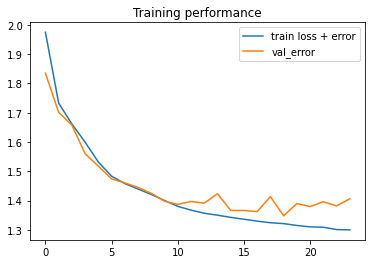

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

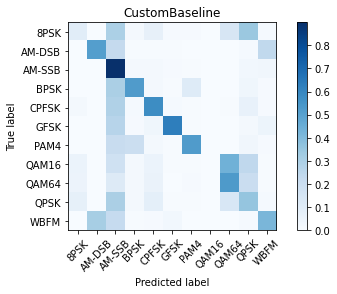

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08655274888558692


Overall Accuracy:  0.09279112754158965


Overall Accuracy:  0.09367267585719335


Overall Accuracy:  0.10154602951510892


Overall Accuracy:  0.11343930635838151


Overall Accuracy:  0.17687074829931973


Overall Accuracy:  0.3027588677893228


Overall Accuracy:  0.4095203488372093


Overall Accuracy:  0.483493077742279
Overall Accuracy:  0.5923795830337887


Overall Accuracy:  0.6695715323166304


Overall Accuracy:  0.6992426974395961


Overall Accuracy:  0.6986717267552183


Overall Accuracy:  0.683955223880597
Overall Accuracy:  0.6512968299711815


Overall Accuracy:  0.6766314254465913
Overall Accuracy:  0.6834505738615327


Overall Accuracy:  0.6731854080481384
Overall Accuracy:  0.6949152542372882


Overall Accuracy:  0.660573476702509


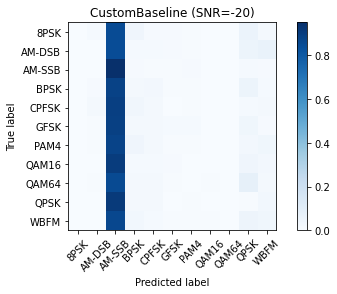

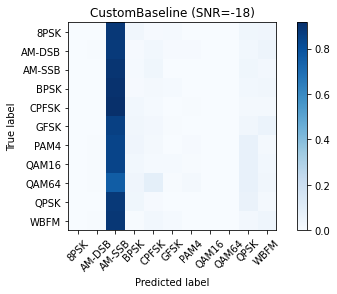

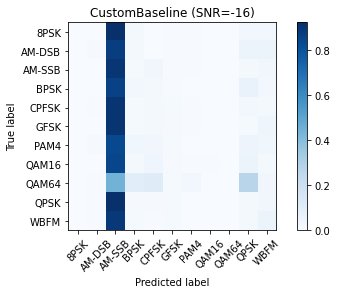

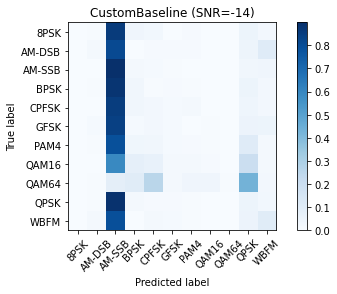

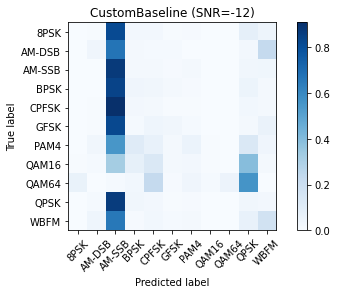

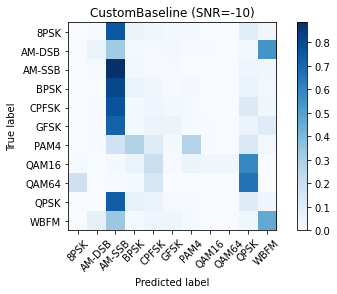

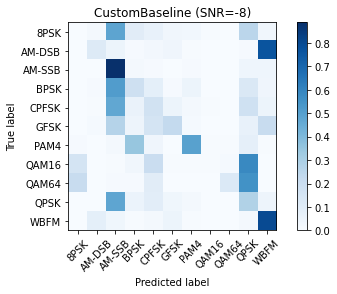

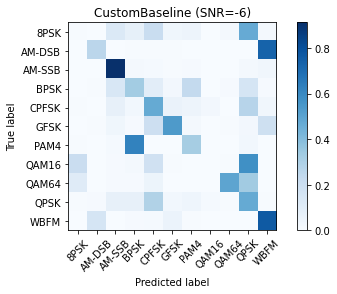

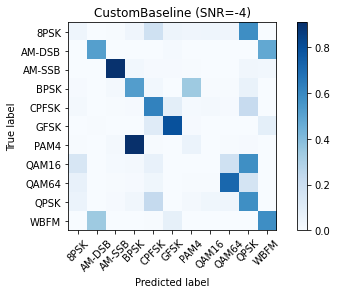

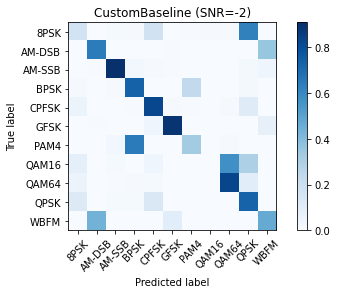

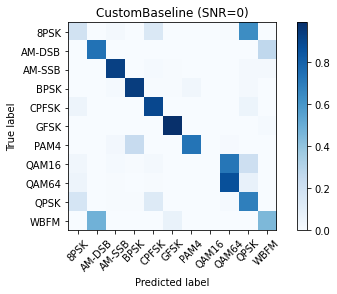

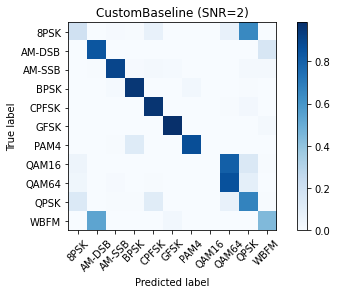

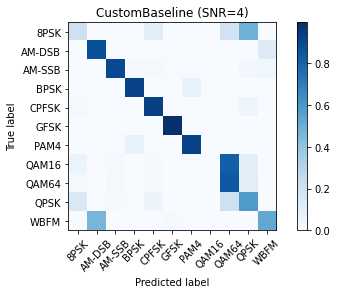

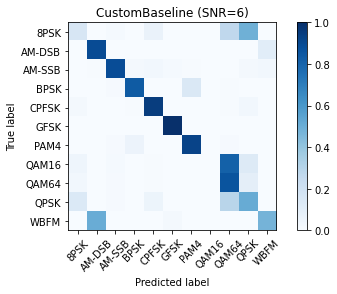

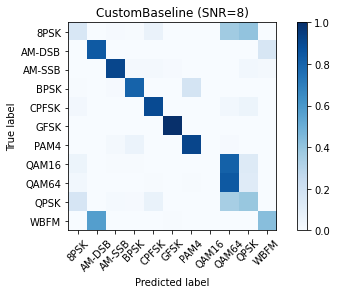

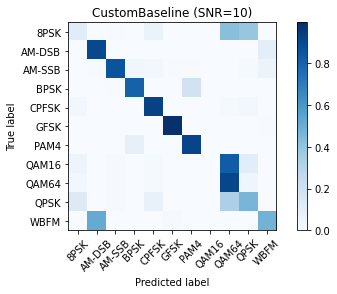

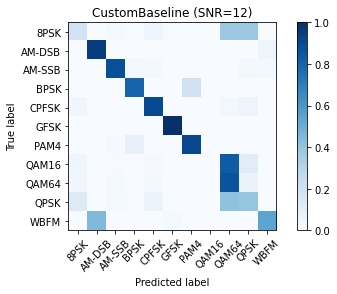

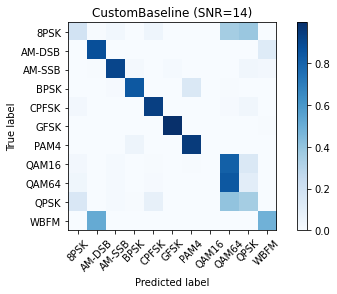

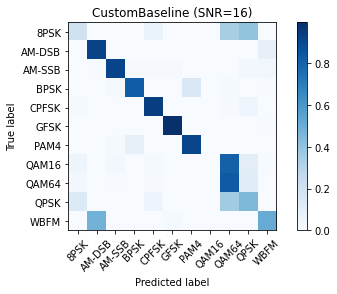

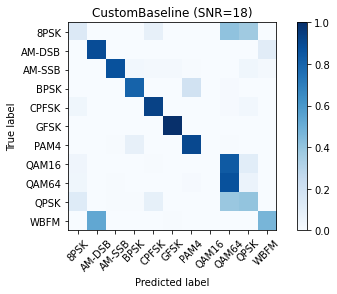

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,10,11,17,30,40,48,59,66,69,69,68,65,67,68,67,69,66


In [18]:
import statistics

statistics.mean(acc.values())

0.4622259331259531

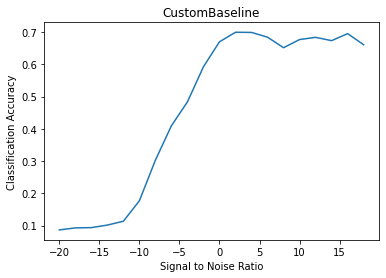

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)